### cos 함수를 이용하여 데이터 만들기

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
import numpy as np
a = np.arange(10)
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
np.where(a<5,a,10*a)

array([ 0,  1,  2,  3,  4, 50, 60, 70, 80, 90])

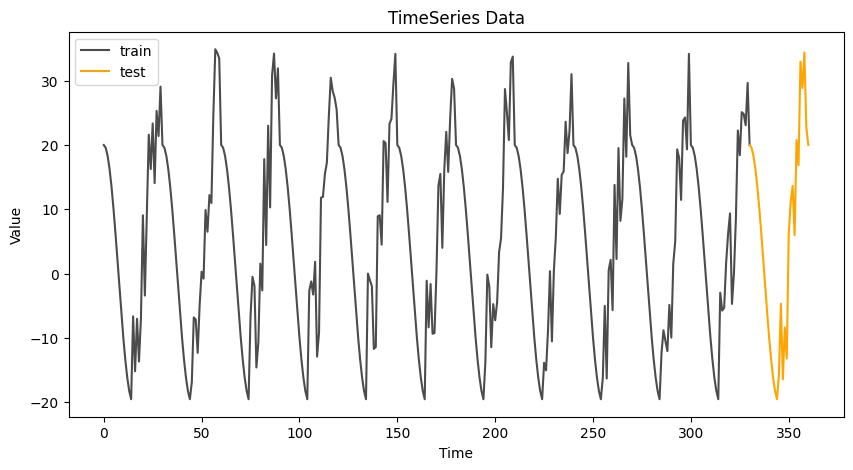

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2020)

time = np.arange(30 * 12 + 1)
month_time = (time % 30) / 30
time_series = 20 * np.where(month_time < 0.5,
                          np.cos(2 * np.pi * month_time),
                          np.cos(2 * np.pi * month_time) + np.random.random(361))

plt.figure(figsize = (10, 5))
plt.title('TimeSeries Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(np.arange(0, 30 * 11 + 1), time_series[:30 * 11 + 1], color = 'black', alpha = 0.7, label = 'train') # 학습용 데이터
plt.plot(np.arange(30 * 11, 30 * 12 + 1), time_series[30 * 11:], color = 'orange', label = 'test') # 테스트용 데이터
plt.legend()

### 전처리 과정 수행하기

In [ ]:
def make_sequence(time_series, n):
    x_train, y_train = list(), list()

    for i in range(len(time_series)):
        x = time_series[i:(i + n)]
        if (i + n) < len(time_series):
            x_train.append(x)
            y_train.append(time_series[i + n])
        else:
            break

    return np.array(x_train), np.array(y_train)

n = 10
x_train, y_train = make_sequence(time_series, n)

x_train = x_train.reshape(-1, n, 1)
y_train = y_train.reshape(-1, 1)

from sklearn.model_selection import train_test_split

patial_x_train = x_train[:30 * 11]
patial_y_train = y_train[:30 * 11]
x_test = x_train[30 * 11:]
y_test = y_train[30 * 11:]

print('train:', patial_x_train.shape, patial_y_train.shape)
print('test:',x_test.shape, y_test.shape)

train: (330, 10, 1) (330, 1)
test: (21, 10, 1) (21, 1)


## 데이터 형태 확인하기

In [ ]:
test_arr = np.arange(100)
a, b = make_sequence(test_arr, 10)

for i in range(1, 4):
    print(a[i],'|', b[i])


[ 1  2  3  4  5  6  7  8  9 10] | 11
[ 2  3  4  5  6  7  8  9 10 11] | 12
[ 3  4  5  6  7  8  9 10 11 12] | 13


### SimpleRNN을 사용하여 모델 구성하기

In [ ]:
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense,Conv1D
from tensorflow.keras.models import Sequential

model = Sequential()
# SimpleRNN 층을 첫 번째 층으로 사용하는 경우,
# 반드시 input_shape를 명시해주어야 합니다.
model.add(SimpleRNN(units = 32, activation = 'tanh', input_shape = (n, 1)))
# model.add(Conv1D(32,kernel_size = 3,activation = 'tanh',input_shape = (n,1)))
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1121 (4.38 KB)
Trainable params: 1121 (4.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 모델 학습시키기

In [ ]:
model.fit(x_train, y_train, epochs = 1000, batch_size = 128)

Epoch 1/1000
3/3 [==============================] - 0s 18ms/step - loss: 28.1226
Epoch 2/1000
3/3 [==============================] - 0s 16ms/step - loss: 27.8167
Epoch 3/1000
3/3 [==============================] - 0s 15ms/step - loss: 27.8381
Epoch 4/1000
3/3 [==============================] - 0s 19ms/step - loss: 27.6636
Epoch 5/1000
3/3 [==============================] - 0s 14ms/step - loss: 27.6240
Epoch 6/1000
3/3 [==============================] - 0s 16ms/step - loss: 27.4156
Epoch 7/1000
3/3 [==============================] - 0s 18ms/step - loss: 27.5098
Epoch 8/1000
3/3 [==============================] - 0s 12ms/step - loss: 27.1932
Epoch 9/1000
3/3 [==============================] - 0s 29ms/step - loss: 27.1913
Epoch 10/1000
3/3 [==============================] - 0s 13ms/step - loss: 26.9546
Epoch 11/1000
3/3 [==============================] - 0s 16ms/step - loss: 26.8978
Epoch 12/1000
3/3 [==============================] - 0s 14ms/step - loss: 26.7426
Epoch 13/1000
3/3 [======


#### 예측 결과 그려보기

1/1 [==============================] - 0s 19ms/step


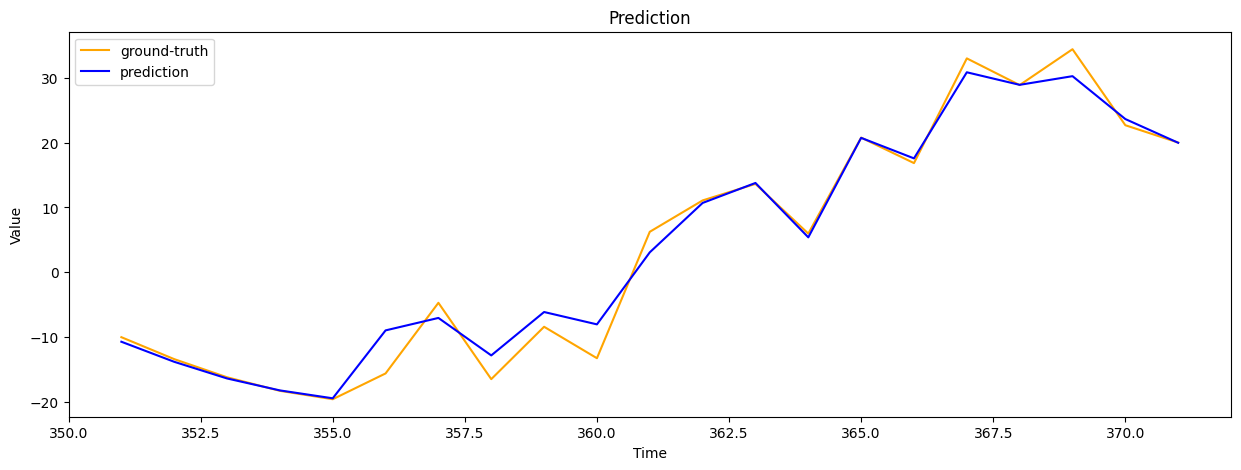

In [ ]:
pred = model.predict(x_test)

pred_range = np.arange(len(y_train), len(y_train) + len(pred))

plt.figure(figsize=(15,5))
plt.title('Prediction')
plt.xlabel('Time'); plt.ylabel('Value')
plt.plot(pred_range, y_test.reshape(-1,), color='orange', label='ground-truth')
plt.plot(pred_range, pred.reshape(-1,), color='blue', label='prediction')
plt.legend()
plt.show()

## Numpy로 RNN 구현하기

<img src='https://user-images.githubusercontent.com/24144491/49584602-36d75c80-f99f-11e8-801e-c790f1204ff7.png'>


### Numpy로 RNN의 순전파를 직접 구현해보는 실습


---


**RNN 기본 수식**

$$
h_t = \tanh(W_{xh} x_t + W_{hh} h_{t-1} + b_h)
$$

- $ x_t $ : t번째 입력(단어 벡터)
- $ h_{t-1} $ : 이전 hidden state
- $ W_{xh} $ : 입력 → 은닉 가중치
- $ W_{hh} $ : 은닉 → 은닉 가중치
- $ \tanh$ : 비선형 활성함수

초기 hidden state:
$$
h_0 = 0
$$

출력층:

$$
y_t = W_{hy} h_t + b_y
$$


In [ ]:
import numpy as np


timesteps = 100               # 시퀀스 길이 (T = 100)
input_features = 32           # 각 time step의 입력 벡터 크기
output_features = 64          # 은닉 상태(hidden state)의 차원
lr = 0.001                    # 학습률
epochs = 50                   # 학습 반복 횟수


# 무작위 입력 시퀀스 생성: shape = (100, 32)
inputs = np.random.random((timesteps, input_features))

# 타깃 벡터 (마지막 hidden state를 이 target에 가깝게 만듦)
target = np.ones((output_features,))   # (64,)  간단하게 모두 1로 설정

# 초기 은닉 상태 h_0 = 0 벡터: shape = (64,)
state_0 = np.zeros((output_features,))

# RNN 가중치 행렬 초기화
# SimpleRNN의 수식: h_t = tanh(W·x_t + U·h_{t-1} + b)
np.random.seed(0)
W = np.random.randn(output_features, input_features) * 0.1   # 입력 가중치 W (64, 32)
U = np.random.randn(output_features, output_features) * 0.1  # 순환 가중치 U (64, 64)
b = np.zeros((output_features,))                             # 편향 b (64,)
#Tip) 가중치를 가중치 초기화하는 방법(he,Xavier(Glorot))등이 효과가 있을때도 있다.
# + RNN에서는 tanh 활성화가 기본이므로, Xavier(Glorot)가 더 효과적

# MSE loss 함수
def mse_loss(h_T, target):
    return 0.5 * np.sum((h_T - target) ** 2)

#학습 루프(forward+ BPTT)-> 직관적으로 보이지는 않음 -> 기능별로 분리는 이거 끝나고 진행.
for epoch in range(1, epochs + 1): #파이썬 0부터 세기 때문에 epochs+1해줘야 자연수입니다.
    # ---------- 순전파 ----------
    # 모든 hidden state를 저장 (BPTT에 필요)
    states = [state_0]       # h_0 포함 (길이: T+1)
    state_t = state_0

    for input_t in inputs:
        # h_t = tanh(W x_t + U h_{t-1} + b)
        z_t = np.dot(W, input_t) + np.dot(U, state_t) + b
        state_t = np.tanh(z_t)

        states.append(state_t)   # h_t 저장

    # 최종 출력 (마지막 hidden state)
    h_T = states[-1]

    # 손실 계산
    loss = mse_loss(h_T, target)

    # ---------- 역전파 (BPTT) ----------
    # 기울기 초기화
    dW = np.zeros_like(W)
    dU = np.zeros_like(U)
    db = np.zeros_like(b)

    # 마지막 시점에서 시작: dL/dh_T
    dh_next = (h_T - target)  # (64,)


    # 시간축 역순으로 내려가면서 gradient 누적
    # t 인덱스: inputs[t] → states[t] = h_{t}, states[t+1] = h_{t+1}
    for t in reversed(range(timesteps)):
        #reverse(오로지 list에서만 가능, return None(원본 수정이 안됨.))
        #reversed(모두 사용 가능함. Iterable Object를 뒤집는 수행)
        ##reverse 기능 + 객체에 영향이 X(새로운 객체를 반환) + iterable
        ## for i range(5,-1,-1):
        ## 같은 원소를 역방향으로 담고 있는 동일한 크기의 새로운 원소를 만들기 때문에 메모리 비효율
        h_t = states[t+1]      # 현재 hidden: h_t
        h_prev = states[t]     # 이전 hidden: h_{t-1}
        x_t = inputs[t]        # 현재 입력: x_t

        # 현재 시점의 total gradient dL/dh_t
        dh = dh_next           # (64,)

        # tanh 역전파: h_t = tanh(z_t)
        # dL/dz_t = dL/dh_t * (1 - h_t^2)
        dz = dh * (1.0 - h_t ** 2)   # (64,)

        # 파라미터 기울기 누적
        dW += np.outer(dz, x_t)      # (64, 32)
        dU += np.outer(dz, h_prev)   # (64, 64)
        db += dz                     # (64,)

        # 이전 hidden으로 전파되는 gradient: dL/dh_{t-1}
        dh_next = np.dot(U.T, dz)    # (64,)

    # ---------- 파라미터 업데이트 (GD 한 스텝) ----------
    W -= lr * dW
    U -= lr * dU
    b -= lr * db

    # 로그 출력
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d} | Loss: {loss:.4f}")


Epoch   1 | Loss: 44.9523
Epoch   5 | Loss: 35.5392
Epoch  10 | Loss: 26.6864
Epoch  15 | Loss: 21.4972
Epoch  20 | Loss: 17.8204
Epoch  25 | Loss: 14.9135
Epoch  30 | Loss: 12.5329
Epoch  35 | Loss: 10.5730
Epoch  40 | Loss: 8.9731
Epoch  45 | Loss: 7.6801
Epoch  50 | Loss: 6.6391


In [ ]:
import numpy as np

# 재현성을 위한 seed
np.random.seed(0)

# 순전파: forward_rnn
def forward_rnn(inputs, W, U, b, state_0=None):
    """
    inputs : (T, input_features)
    W      : (hidden_size, input_features)
    U      : (hidden_size, hidden_size)
    b      : (hidden_size,)
    state_0: (hidden_size,)
    반환:
      states: 리스트 길이 T+1, [h_0, h_1, ..., h_T]
    """
    timesteps = inputs.shape[0]
    hidden_size = W.shape[0]

    if state_0 is None:
        state_0 = np.zeros((hidden_size,))

    states = [state_0]
    state_t = state_0

    for input_t in inputs:
        # h_t = tanh(W x_t + U h_{t-1} + b)
        z_t = np.dot(W, input_t) + np.dot(U, state_t) + b
        state_t = np.tanh(z_t)
        states.append(state_t)

    return states  # h_0 ~ h_T


#  Loss 함수 (MSE, 마지막 hidden에 대해)
def mse_loss(h_T, target):
    """
    h_T   : (hidden_size,)
    target: (hidden_size,)
    """
    return 0.5 * np.sum((h_T - target) ** 2)

def backward_rnn(inputs, states, target, W, U, b):
    """
    inputs : (T, input_features)
    states : 길이 T+1 리스트 [h_0, ..., h_T]
    target : (hidden_size,)
    W, U, b: 파라미터 (형태는 forward와 동일)

    반환:
      dW, dU, db: 각 파라미터에 대한 gradient
      grad_norm_per_t: time step별 gradient norm (||dz_t||)
    """
    timesteps = inputs.shape[0]
    hidden_size = W.shape[0]

    # gradient 초기화
    dW = np.zeros_like(W)
    dU = np.zeros_like(U)
    db = np.zeros_like(b)

    # time step별 gradient norm 기록 (vanishing 관찰용)
    grad_norm_per_t = np.zeros(timesteps)

    # 마지막 시점에서 시작: dL/dh_T
    h_T = states[-1]
    dh_next = (h_T - target)  # (hidden_size,)

    # t = T-1, ..., 0 순서로 역전파
    for t in reversed(range(timesteps)):
        h_t = states[t+1]   # 현재 hidden h_t
        h_prev = states[t]  # 이전 hidden h_{t-1}
        x_t = inputs[t]     # 현재 입력 x_t

        # 현재 시점의 dL/dh_t
        dh = dh_next  # (hidden_size,)

        # tanh 역전파: h_t = tanh(z_t)
        # dL/dz_t = dL/dh_t * (1 - h_t^2)
        dz = dh * (1.0 - h_t**2)  # (hidden_size,)

        # time step별 gradient 크기 기록
        grad_norm_per_t[t] = np.linalg.norm(dz)

        # 파라미터 gradient 누적
        dW += np.outer(dz, x_t)    # (hidden_size, input_features)
        dU += np.outer(dz, h_prev) # (hidden_size, hidden_size)
        db += dz                   # (hidden_size,)

        # 이전 hidden으로 gradient 전파
        dh_next = np.dot(U.T, dz)  # (hidden_size,)

    return dW, dU, db, grad_norm_per_t

In [ ]:
def run_experiment(timesteps=100,
                   input_features=32,
                   hidden_size=64,
                   init_scale=0.1,
                   lr=0.001,
                   epochs=30,
                   verbose=True):
    """
    timesteps  : 시퀀스 길이
    init_scale : 가중치 초기 스케일 (작게/크게에 따른 학습 차이)
    epochs     : 학습 반복 횟수
    """

    # 1) 데이터 생성
    inputs = np.random.randn(timesteps, input_features)
    target = np.ones((hidden_size,))  # 마지막 hidden을 1로 맞추는 토이 타깃

    # 2) 파라미터 초기화 (스케일 조절)
    W = np.random.randn(hidden_size, input_features) * init_scale
    U = np.random.randn(hidden_size, hidden_size) * init_scale
    b = np.zeros((hidden_size,))

    loss_history = []
    first_epoch_grad_norm_per_t = None  # 첫 epoch의 grad profile 저장용

    for epoch in range(1, epochs + 1):
        # ----- forward -----
        states = forward_rnn(inputs, W, U, b)
        h_T = states[-1]
        loss = mse_loss(h_T, target)
        loss_history.append(loss)

        # ----- backward (BPTT) -----
        dW, dU, db, grad_norm_per_t = backward_rnn(inputs, states, target, W, U, b)

        # 첫 epoch의 gradient profile 저장
        if epoch == 1:
            first_epoch_grad_norm_per_t = grad_norm_per_t.copy()

        # ----- 파라미터 업데이트 -----
        W -= lr * dW
        U -= lr * dU
        b -= lr * db

        if verbose and (epoch == 1 or epoch % 10 == 0 or epoch == epochs):
            print(f"[T={timesteps:3d}, init={init_scale:.3f}] "
                  f"Epoch {epoch:3d} | Loss: {loss:.4f}")

    # 요약 정보 출력
    if verbose:
        print(f"\n=== 실험 요약: T={timesteps}, init_scale={init_scale} ===")
        print(f"초기 Loss: {loss_history[0]:.4f}")
        print(f"마지막 Loss: {loss_history[-1]:.4f}")

        # gradient vanishing 관찰용
        print("첫 epoch 기준 time step별 gradient norm (일부):")
        print("  앞쪽 5개:", first_epoch_grad_norm_per_t[:5])
        print("  뒤쪽 5개:", first_epoch_grad_norm_per_t[-5:])
        print("  min / max:", np.min(first_epoch_grad_norm_per_t),
              "/", np.max(first_epoch_grad_norm_per_t))
        print()

    return {
        "loss_history": loss_history,
        "grad_norm_per_t": first_epoch_grad_norm_per_t
    }

In [ ]:
# 실험 설정들
configs = [
    # (timesteps, init_scale)
    (50, 0.1),
    (100, 0.1),
    (200, 0.1),
    (100, 0.01),
    (100, 0.5),
]

results = {}

for timesteps, init_scale in configs:
    print("============================================")
    print(f"실험 시작: T={timesteps}, init_scale={init_scale}")
    print("============================================")

    key = f"T{timesteps}_init{init_scale}"
    results[key] = run_experiment(
        timesteps=timesteps,
        input_features=32,
        hidden_size=64,
        init_scale=init_scale,
        lr=0.001,
        epochs=40,
        verbose=True
    )


실험 시작: T=50, init_scale=0.1
[T= 50, init=0.100] Epoch   1 | Loss: 40.2968
[T= 50, init=0.100] Epoch  10 | Loss: 16.0843
[T= 50, init=0.100] Epoch  20 | Loss: 7.4127
[T= 50, init=0.100] Epoch  30 | Loss: 3.7383
[T= 50, init=0.100] Epoch  40 | Loss: 2.2407

=== 실험 요약: T=50, init_scale=0.1 ===
초기 Loss: 40.2968
마지막 Loss: 2.2407
첫 epoch 기준 time step별 gradient norm (일부):
  앞쪽 5개: [3.13967673e-10 5.22932557e-10 8.06770860e-10 1.17230027e-09
 1.81764369e-09]
  뒤쪽 5개: [0.78915652 1.25883304 1.9451602  3.98008125 6.75261651]
  min / max: 3.139676734510882e-10 / 6.752616506891909

실험 시작: T=100, init_scale=0.1
[T=100, init=0.100] Epoch   1 | Loss: 39.0448
[T=100, init=0.100] Epoch  10 | Loss: 18.1133
[T=100, init=0.100] Epoch  20 | Loss: 8.1885
[T=100, init=0.100] Epoch  30 | Loss: 4.7719
[T=100, init=0.100] Epoch  40 | Loss: 3.6195

=== 실험 요약: T=100, init_scale=0.1 ===
초기 Loss: 39.0448
마지막 Loss: 3.6195
첫 epoch 기준 time step별 gradient norm (일부):
  앞쪽 5개: [1.78490786e-22 2.98574705e-22 5.20036149e-2

RNN이 긴 시퀀스를 역전파할 때 앞부분의 gradient는 거의 0으로 사라지고, 끝부분은 폭발적으로 커지는—vanishing과 exploding이 동시에 일어나는 구조적 한계를 보여주는 plot

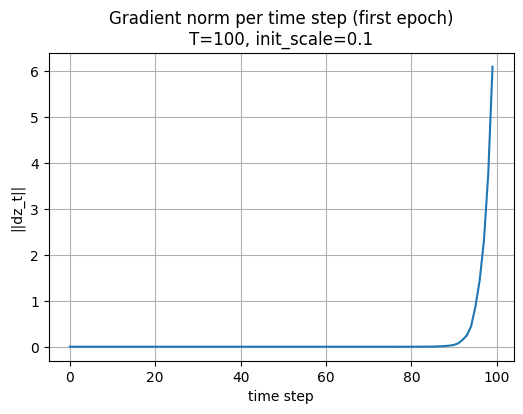

In [ ]:
import matplotlib.pyplot as plt

# 예: T=100, init_scale=0.1 에 대한 gradient profile 시각화
key = "T100_init0.1"
grad_profile = results[key]["grad_norm_per_t"]
plt.figure(figsize=(6,4))
plt.plot(grad_profile)
plt.title("Gradient norm per time step (first epoch)\nT=100, init_scale=0.1")
plt.xlabel("time step")
plt.ylabel("||dz_t||")
plt.grid(True)
plt.show()

### 간단한 RNN 실습

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--- model_0: training complete ---
--- model_1: training complete ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


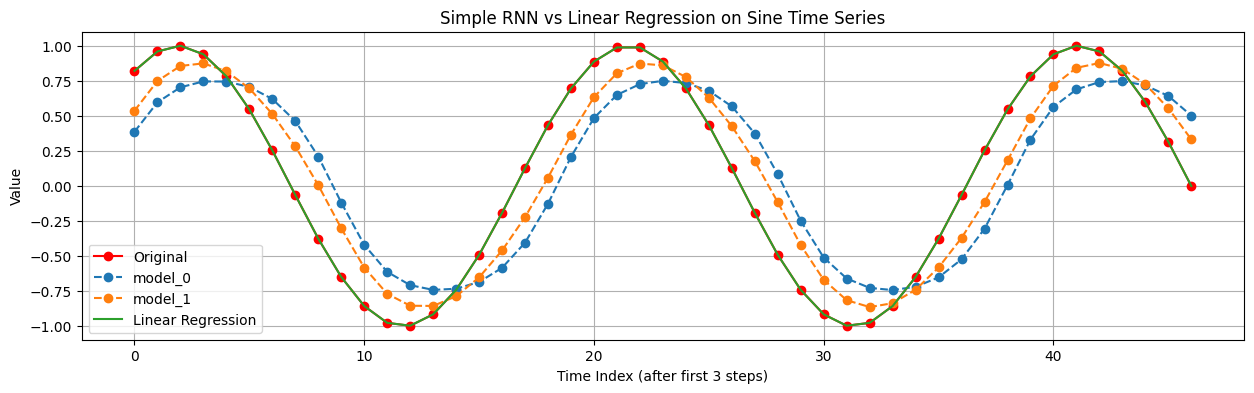

In [ ]:
#이전 시점 3개 값을 사용해 다음 시점 1개 값을 예측 (many-to-one)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

# 데이터 생성(sin 파형 생성)
n_points = 50
freq = 0.125
sine_series = np.sin(2 * np.pi * freq * np.linspace(0, 20, n_points))

#(입력 3개 → 출력 1개) 시계열 데이터셋 구성
timestep = 3  # t-3, t-2, t-1 → t 예측

X_list, y_list = [], []

for t in range(timestep, len(sine_series)):
    # t-3, t-2, t-1
    past_values = [sine_series[t - k] for k in range(timestep, 0, -1)]
    X_list.append(past_values)
    # t 시점 값
    y_list.append(sine_series[t])

X = np.array(X_list).reshape(-1, timestep, 1)  # (n_samples, timesteps, features)
y = np.array(y_list).reshape(-1, 1)            # (n_samples, 1)

# 선형회귀 모델
linear_reg = LinearRegression()
linear_reg.fit(X.reshape(len(X), timestep), y)

#  Simple RNN 모델 정의
np.random.seed(0)  # 재현성 확보

models = [
    # model_0: RNN만 사용
    Sequential([
        SimpleRNN(units=1, input_shape=(timestep, 1)),
    ]),

    # model_1: RNN + Dense 레이어 추가
    Sequential([
        SimpleRNN(units=1, input_shape=(timestep, 1)),
        Dense(10, activation='linear'),
        Dense(1, activation='linear'),
    ]),
]

#모델 학습
for i, model in enumerate(models):
    model.compile(loss='mse', optimizer='sgd')
    model.fit(X, y, epochs=150, verbose=0)
    print(f"--- model_{i}: training complete ---")

#  예측 및 시각화
plt.figure(figsize=(15, 4))

# 원래 시계열 (입력 구간 이후부터)
plt.plot(sine_series[timestep:], 'ro-', label='Original')

# RNN 모델 예측
for i, model in enumerate(models):
    y_pred_rnn = model.predict(X)
    plt.plot(y_pred_rnn, '--o', label=f'model_{i}')

# 선형회귀 예측
y_pred_lin = linear_reg.predict(X.reshape(len(X), timestep))
plt.plot(y_pred_lin, label='Linear Regression')

plt.legend()
plt.title('Simple RNN vs Linear Regression on Sine Time Series')
plt.xlabel('Time Index (after first 3 steps)')
plt.ylabel('Value')
plt.grid(True)
plt.show()

### 원-핫 해싱(One-Hot Hashing)

원-핫 해싱은 어휘 사전(vocabulary)의 크기가 매우 클 때, 모든 단어에 대해 고유한 인덱스를 만드는 대신 **해시 함수로 단어를 고정된 크기의 벡터로 매핑하는 기법**

---
- 모든 단어를 명시적으로 번호로 매핑하는 대신 해시 함수(hash function)를 사용하여 벡터의 특정 위치에 단어를 매핑합니다.
- 벡터의 크기는 **고정된 차원**으로 설정합니다.

---
- 어떤 단어든 해싱 과정을 통해 **벡터 내 하나의 위치만 1로 활성화**됨.
- 어휘 사전이 매우 커도 벡터 크기를 고정할 수 있어 **메모리 효율적**임.
- 계산량이 줄어 NLP 모델 전처리에 자주 사용됨.

---
**주의할 점: 해시 충돌(Hash Collision)**
- 서로 다른 단어가 **같은 해시 값**으로 매핑될 수 있음.
- 충돌이 많아지면 단어 구분이 어려워져 모델 성능이 떨어질 수 있음.
- 따라서 **해시 벡터의 차원을 충분히 크게 설정**해야 충돌을 줄일 수 있음.



In [ ]:
import numpy as np

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# 단어를 크기가 1,000인 벡터로 저장합니다.
dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        # 단어를 해싱하여 0과 1,000 사이의 랜덤한 정수 인덱스로 변환합니다.
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

# 결과 출력
np.set_printoptions(threshold=10, suppress=True)  # 보기 좋게 출력
print("Shape of results:", results.shape)
print("Sample encoding (first sentence):")
print(results[0])

Shape of results: (2, 10, 1000)
Sample encoding (first sentence):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#원 핫 인코딩 VS 임베딩

<img src = 'https://s3.amazonaws.com/book.keras.io/img/ch6/word_embeddings.png'>

### Embedding 층과 RNN의

RNN(Recurrent Neural Network)은 **시퀀스(sequence)** 데이터를 처리하기 위한 모델.  
하지만 시퀀스를 구성하는 값이 **정수 인덱스 형태**일 경우, 이 숫자를 그대로 RNN에 넣을 수 없습니다.  
이를 해결하는 단계가 바로 **Embedding 층**.

---

RNN은 다음과 같은 3차원 형태의 입력을 받습니다.

(batch_size, timesteps, features)

- **timesteps**: 시퀀스 길이  
- **features**: 각 시점의 벡터 크기  

정수 인덱스만 있으면 `features`가 의미 있는 벡터가 아니므로 Embedding 층을 통해 벡터 공간으로 변환해야 합니다.

---

### Embedding 층의 역할

Embedding 층은 아래 기능을 수행.

- 정수 인덱스를 **고정 길이의 실수 벡터로 변환**  
- 출력은 `(timesteps × embedding_dim)` 크기의 벡터 시퀀스  
- 벡터는 학습 과정에서 **자동으로 업데이트**됨

Embedding 층은 정수 기반 시퀀스를 RNN이 처리할 수 있는 **dense vector 시퀀스**로 변환하는 핵심 단계입니다.

---

### 전체 모델 흐름

Embedding 층을 사용한 RNN 모델은 다음 흐름을 따릅니다.

1. **Embedding 층**: 인덱스를 실수 벡터로 변환  
2. **RNN 계열 층(SimpleRNN / LSTM / GRU)**: 벡터 시퀀스를 시간 순서대로 처리  
3. **Dense 층**: 회귀 또는 분류 결과 출력  



In [ ]:
from tensorflow.keras.layers import Embedding

# Embedding 층은 적어도 두 개의 매개변수를 받습니다.
# 가능한 토큰의 개수(여기서는 1,000으로 단어 인덱스 최댓값 + 1입니다)와 임베딩 차원(여기서는 64)입니다
embedding_layer = Embedding(1000, 64)

### Embedding 층의 출력과 동작 방식

Embedding 층은 입력으로 들어오는 **정수 시퀀스**를 크기가 `(samples, sequence_length, embedding_dimensionality)`인  
**3차원 실수 텐서**로 변환.  
이러한 3D 텐서는 **RNN 층, 1D 합성곱 층(Conv1D)** 등에서 바로 처리할 수 있는 형태.

---

### Embedding 층의 내부 구조

Embedding 층을 생성하면 층 내부에는 **정수 인덱스 → 실수 벡터**로 매핑하기 위한 가중치 행렬이 존재.

- 이 가중치는 처음에 무작위로 초기화  
- 훈련 과정에서 역전파(backpropagation)를 통해 값이 조정  
- 최종적으로는 해당 문제에 특화된 벡터 공간(embedding space)이 형성.

Embedding 층은 단순한 인덱스 매핑이 아니라 훈련을 통해 의미 있는 벡터 표현을 학습하는 층



## IMDB 데이터셋 사용하기

인터넷 영화 데이터베이스로부터 가져온 양극단의 리뷰 5만 개로 이루어진 IMDB 데이터셋을 이용해서 긍정/부정으로 분류하는 예제이다. 훈련 데이터 2만 5,000개와 테스트 데이터 2만 5000개로 이루어져 있다.


In [ ]:
#영화 리뷰 분류
#0. 사용할 패키지 불러오기
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17464789/17464789 [==============================] - 0s 0us/step


One-hot encoding(특정한 인덱스(ID)로 인코딩을 해줌)

In [ ]:
import numpy as np

def vectorize_sequence(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    #빈칸을 만들어 놓음.
    #크기가 (len(sequences), dimension)이고 모든 원소가 0인 행렬 만들기
    for i, sequence in enumerate(sequences): #enumerate (index,value) 동시에 접근할수 있는 문법.
        results[i, sequence] = 1.
        #result[i] 에서 특정 인덱스의 위치를 1로 만듦
    return results
x_train =vectorize_sequence(train_data)
x_test = vectorize_sequence(test_data)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [ ]:
x_train

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                160016    
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 160161 (625.63 KB)
Trainable params: 160161 (625.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [ ]:
partial_x_train

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [ ]:
history = model.fit(partial_x_train, partial_y_train, epochs= 10, batch_size = 512, validation_data = (x_val, y_val))

Epoch 1/10
30/30 [==============================] - 6s 113ms/step - loss: 0.5817 - acc: 0.7584 - val_loss: 0.4208 - val_acc: 0.8544
Epoch 2/10
30/30 [==============================] - 1s 41ms/step - loss: 0.3146 - acc: 0.8957 - val_loss: 0.3022 - val_acc: 0.8861
Epoch 3/10
30/30 [==============================] - 1s 48ms/step - loss: 0.2118 - acc: 0.9292 - val_loss: 0.2854 - val_acc: 0.8863
Epoch 4/10
30/30 [==============================] - 1s 47ms/step - loss: 0.1623 - acc: 0.9494 - val_loss: 0.2785 - val_acc: 0.8879
Epoch 5/10
30/30 [==============================] - 1s 31ms/step - loss: 0.1253 - acc: 0.9649 - val_loss: 0.2885 - val_acc: 0.8867
Epoch 6/10
30/30 [==============================] - 1s 41ms/step - loss: 0.0987 - acc: 0.9752 - val_loss: 0.3037 - val_acc: 0.8840
Epoch 7/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0775 - acc: 0.9831 - val_loss: 0.3240 - val_acc: 0.8806
Epoch 8/10
30/30 [==============================] - 1s 42ms/step - loss: 0.0600 - 

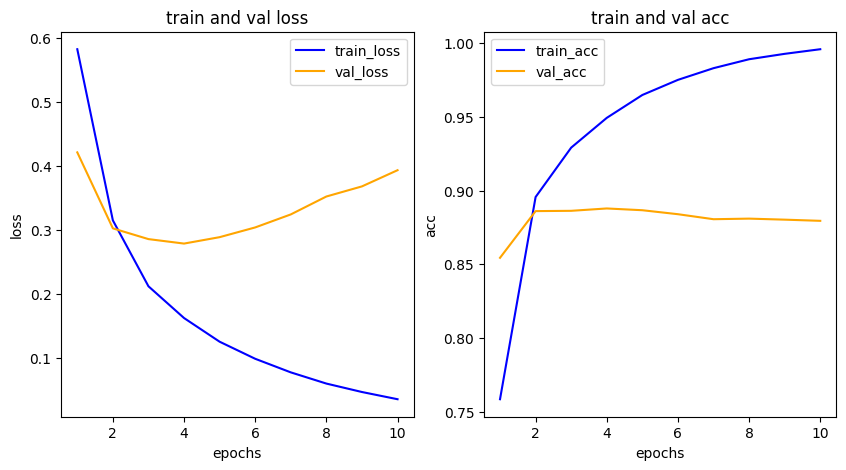

In [ ]:
#학습결과 그려보기
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] # 검증 데이터가 있는 경우 val_ 수식어가 붙는다.

epochs = range(1,len(loss)+1 )
fig = plt.figure(figsize= (10,5) )

# 학습 및 검증 손실 그리기

ax1 = fig.add_subplot(1,2,1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 학습 및 검증 정확도 그리기
ax2 = fig.add_subplot(1,2,2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()


plt.show()

In [ ]:
model.evaluate(x_test,y_test,verbose=1)

782/782 [==============================] - 3s 4ms/step - loss: 0.4246 - acc: 0.8644


[0.42462781071662903, 0.8644400238990784]

In [ ]:
from tensorflow.keras.datasets import imdb

num_words = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)

from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 500

pad_X_train = pad_sequences(X_train, maxlen=max_len)
pad_X_test = pad_sequences(X_test, maxlen=max_len)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding

model = Sequential()
model.add(Embedding(input_dim = num_words, output_dim = 32))
# 새로운 인자 3개가 사용되었습니다.
# return_sequences, dropout, recurrent_dropout
# return_sequences = True : 모든 시점의 은닉 상태를 출력
# return_sequences = True : 순환되는 은닉 상태에 드롭아웃을 적용
model.add(SimpleRNN(32, return_sequences = True, dropout = 0.15, recurrent_dropout = 0.15))
model.add(SimpleRNN(32))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics = ['acc'])

# model.summary()
history = model.fit(pad_X_train, y_train,
                    batch_size = 32, epochs = 15,
                    validation_split = 0.2)

Epoch 1/15
625/625 [==============================] - 581s 920ms/step - loss: 0.6774 - acc: 0.5628 - val_loss: 0.5800 - val_acc: 0.6900
Epoch 2/15
625/625 [==============================] - 558s 893ms/step - loss: 0.5040 - acc: 0.7574 - val_loss: 0.4710 - val_acc: 0.7838
Epoch 3/15
625/625 [==============================] - 536s 858ms/step - loss: 0.4461 - acc: 0.8009 - val_loss: 0.4384 - val_acc: 0.8196
Epoch 4/15
625/625 [==============================] - 532s 851ms/step - loss: 0.4178 - acc: 0.8181 - val_loss: 0.5924 - val_acc: 0.6888
Epoch 5/15
625/625 [==============================] - 526s 842ms/step - loss: 0.4464 - acc: 0.7944 - val_loss: 0.5660 - val_acc: 0.7000
Epoch 6/15
625/625 [==============================] - 531s 849ms/step - loss: 0.4484 - acc: 0.7916 - val_loss: 0.4955 - val_acc: 0.7662
Epoch 7/15
625/625 [==============================] - 526s 841ms/step - loss: 0.3662 - acc: 0.8441 - val_loss: 0.4195 - val_acc: 0.8316
Epoch 8/15
625/625 [============================

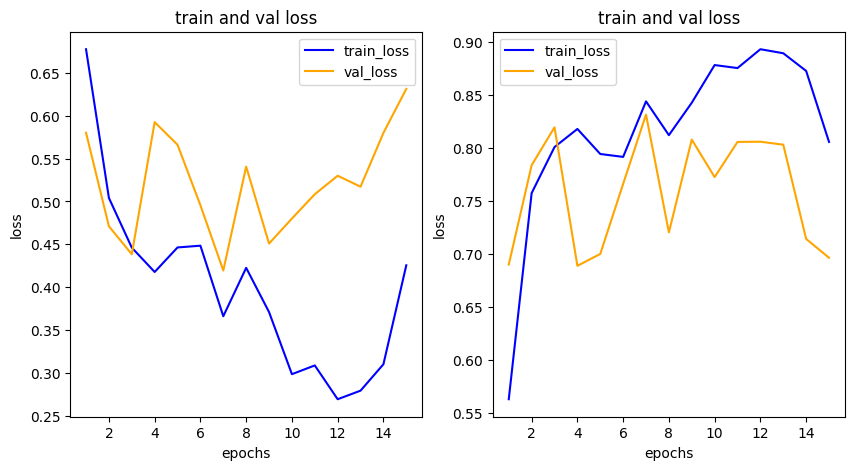

In [ ]:
#학습결과 그려보기
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] # 검증 데이터가 있는 경우 val_ 수식어가 붙는다.

epochs = range(1,len(loss)+1 )
fig = plt.figure(figsize= (10,5) )

# 학습 및 검증 손실 그리기

ax1 = fig.add_subplot(1,2,1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 학습 및 검증 정확도 그리기
ax2 = fig.add_subplot(1,2,2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()


plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_words = 10000    # 상위 10,000 단어만 사용
max_len = 200        # 시퀀스 길이 (패딩/잘라내기 기준)

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test  = pad_sequences(X_test,  maxlen=max_len)

X_train.shape, X_test.shape


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


((25000, 200), (25000, 200))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam

embedding_dim = 32

def build_simplernn_model(
    hidden_units=32,
    num_layers=1,
    return_sequences_last=False,
    dropout=0.0,
    recurrent_dropout=0.0,
    lr=1e-3
):
    model = Sequential()
    model.add(Embedding(input_dim=num_words,
                        output_dim=embedding_dim,
                        input_length=max_len))

    # 첫 번째 SimpleRNN
    if num_layers == 1:
        # 한 층만 쓰는 경우
        model.add(SimpleRNN(
            hidden_units,
            return_sequences=return_sequences_last,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout
        ))
    else:
        # 여러 층: 중간층은 return_sequences=True
        model.add(SimpleRNN(
            hidden_units,
            return_sequences=True,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout
        ))
        for i in range(num_layers - 2):
            model.add(SimpleRNN(
                hidden_units,
                return_sequences=True,
                dropout=dropout,
                recurrent_dropout=recurrent_dropout
            ))
        # 마지막 RNN 층
        model.add(SimpleRNN(
            hidden_units,
            return_sequences=return_sequences_last,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout
        ))

    # 이진 분류
    model.add(Dense(1, activation='sigmoid'))

    # gradient clipping으로 exploding 방지
    optimizer = Adam(learning_rate=lr, clipnorm=1.0)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['acc']
    )
    return model


In [ ]:
model = build_simplernn_model(
    hidden_units=32,
    num_layers=1,
    return_sequences_last=False,
    dropout=0.2,
    recurrent_dropout=0.0,  # 처음엔 0으로 두고 나중에 실험
    lr=1e-3
)

model.summary()

history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=5,
    validation_split=0.2,
    verbose=2
)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
313/313 - 30s - 96ms/step - acc: 0.6903 - loss: 0.5718 - val_acc: 0.7874 - val_loss: 0.4793
Epoch 2/5
313/313 - 24s - 78ms/step - acc: 0.8491 - loss: 0.3577 - val_acc: 0.8368 - val_loss: 0.3706
Epoch 3/5
313/313 - 15s - 48ms/step - acc: 0.8927 - loss: 0.2743 - val_acc: 0.8372 - val_loss: 0.4148
Epoch 4/5
313/313 - 15s - 48ms/step - acc: 0.9178 - loss: 0.2131 - val_acc: 0.8348 - val_loss: 0.3984
Epoch 5/5
313/313 - 16s - 50ms/step - acc: 0.9420 - loss: 0.1571 - val_acc: 0.8212 - val_loss: 0.4746
Test Loss: 0.4964, Test Acc: 0.8141


In [ ]:
import matplotlib.pyplot as plt

def plot_multi_history(histories, labels):
    """
    여러 Keras history 객체를 한 그래프에 겹쳐서
    Train/Val Loss & Accuracy 비교 플롯을 생성하는 함수
    """
    plt.figure(figsize=(14, 6))

    #  Loss 비교

    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history.history["loss"], label=f"{label} - Train")
        plt.plot(history.history["val_loss"], linestyle="--", label=f"{label} - Val")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Accuracy 비교
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history.history["acc"], label=f"{label} - Train")
        plt.plot(history.history["val_acc"], linestyle="--", label=f"{label} - Val")
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

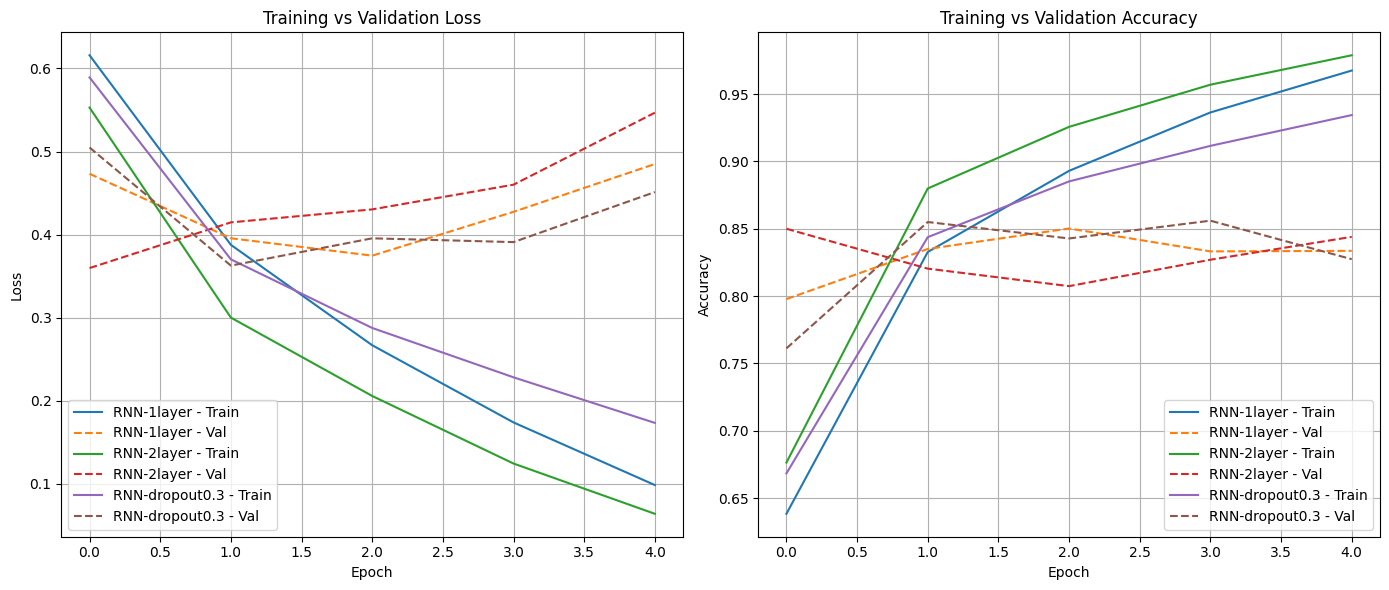

In [ ]:
# 모델 1: 단층 RNN
m1 = build_simplernn_model(hidden_units=32, num_layers=1)
h1 = m1.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=0)

# 모델 2: 2층 RNN
m2 = build_simplernn_model(hidden_units=32, num_layers=2)
h2 = m2.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=0)

# 모델 3: dropout 적용
m3 = build_simplernn_model(hidden_units=32, num_layers=1, dropout=0.3)
h3 = m3.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=0)

plot_multi_history(
    histories=[h1, h2, h3],
    labels=["RNN-1layer", "RNN-2layer", "RNN-dropout0.3"]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


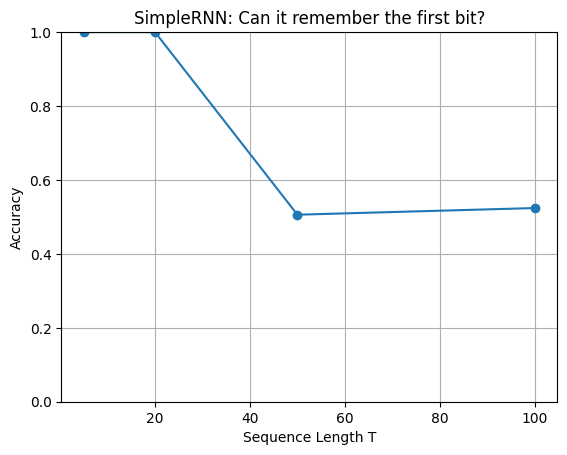

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt

def make_data(T, n=5000):
    X = np.random.randint(0, 2, size=(n, T))    # 0/1 시퀀스
    y = X[:, 0]                                 # 첫 번째 값이 정답
    return X[..., np.newaxis], y                # (batch, T, 1)

def train_rnn(T):
    X, y = make_data(T)
    model = Sequential([
        SimpleRNN(16, input_shape=(T,1)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    h = model.fit(X, y, epochs=5, batch_size=64, verbose=0)
    return h.history['acc'][-1]    # 마지막 accuracy 반환

T_values = [5, 20, 50, 100]
acc_results = [train_rnn(T) for T in T_values]

plt.plot(T_values, acc_results, marker='o')
plt.ylim(0,1)
plt.xlabel("Sequence Length T")
plt.ylabel("Accuracy")
plt.title("SimpleRNN: Can it remember the first bit?")
plt.grid(True)
plt.show()

### 스팸 메일 분류하기(Spam Detection)

- 다운로드 링크 : https://www.kaggle.com/uciml/sms-spam-collection-dataset


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv', encoding='latin1')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5572


In [ ]:
data[:5]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
#Unnamed: 로 시작하는 열을 자동으로 V3,V4 ... 으로 부여하는 for문
# startswith
new_column = []
v_num=1

for col in data.columns:
    if col.startswith('Unnamed'):
        new_column.append(f'v{v_num}')

    else:
        new_column.append(col)
    v_num+=1
data.columns = new_column
data

- Unnamed라는 이름의 3개의 열은 텍스트 분류를 할 때 불필요한 열.
- v1열은 해당 메일이 스팸인지 아닌지를 나타내는 레이블에 해당되는 열
- ham은 정상 메일을 의미하고, spam은 스팸 메일을 의미. v2열은 메일의 본문을 담고있음.

In [ ]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
data[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [ ]:
print('결측값 여부 :',data.isnull().values.any())

결측값 여부 : False


In [ ]:
print('v2열의 유니크한 값 :',data['v2'].nunique())

v2열의 유니크한 값 : 5169


<Axes: xlabel='v1'>

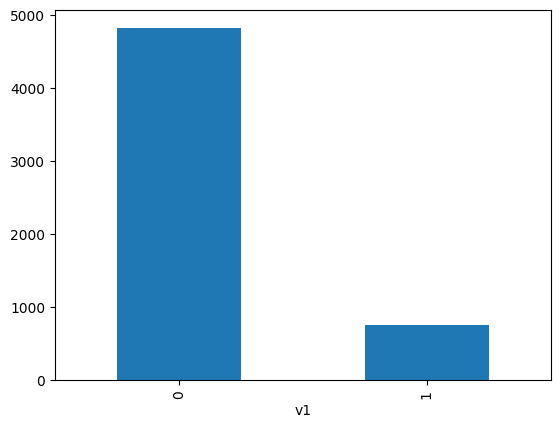

In [ ]:
data['v1'].value_counts().plot(kind='bar')

- 레이블이 대부분 0에 편중되어있는데, 이는 스팸 메일 데이터의 대부분의 메일이 정상 메일임을 의미

In [ ]:
print('정상 메일과 스팸 메일의 개수')
print(data.groupby('v1').size().reset_index(name='count'))

정상 메일과 스팸 메일의 개수
   v1  count
0   0   4825
1   1    747


In [ ]:
print(f'정상 메일의 비율 = {round(data["v1"].value_counts()[0]/len(data) * 100,3)}%')
print(f'스팸 메일의 비율 = {round(data["v1"].value_counts()[1]/len(data) * 100,3)}%')

정상 메일의 비율 = 86.594%
스팸 메일의 비율 = 13.406%


In [ ]:
X_data = data['v2']
y_data = data['v1']
print('메일 본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

메일 본문의 개수: 5572
레이블의 개수: 5572


- 레이블 불균형이 굉장히 심함. 스팸 메일이 굉장히 적음.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [ ]:
print('--------훈련 데이터의 비율-----------')
print(f'정상 메일 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'스팸 메일 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')

--------훈련 데이터의 비율-----------
정상 메일 = 86.583%
스팸 메일 = 13.417%


In [ ]:
print('--------테스트 데이터의 비율-----------')
print(f'정상 메일 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'스팸 메일 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')

--------테스트 데이터의 비율-----------
정상 메일 = 86.637%
스팸 메일 = 13.363%


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
print(X_train_encoded[:5])

[[61, 173, 157, 9, 1443, 65, 25, 17, 2, 452], [51, 1, 293, 1, 58, 14, 57, 6, 238, 10, 19, 60, 20, 26, 149], [3799, 1444, 3800, 350, 599, 75, 239, 674, 2023, 246, 216, 26, 16, 3801, 3, 493, 34, 260, 599, 1126, 3802, 28, 137, 2023, 246, 216, 351], [7, 3803, 43, 41, 3804, 59, 36, 239], [61, 9, 3805, 2568, 707]]


- 각 메일이 정수 인코딩이 되었습니다. 각 정수가 어떤 단어에 부여되었는지 확인

In [ ]:
word_to_index = tokenizer.word_index
print(word_to_index)

{'i': 1, 'to': 2, 'you': 3, 'a': 4, 'the': 5, 'u': 6, 'and': 7, 'is': 8, 'in': 9, 'me': 10, 'my': 11, 'your': 12, 'for': 13, 'it': 14, 'of': 15, 'call': 16, 'have': 17, 'on': 18, '2': 19, 'now': 20, 'that': 21, 'are': 22, 'so': 23, 'not': 24, 'but': 25, 'or': 26, "i'm": 27, 'at': 28, 'if': 29, 'ur': 30, 'do': 31, 'can': 32, 'get': 33, 'be': 34, 'with': 35, 'no': 36, 'just': 37, 'will': 38, 'we': 39, 'this': 40, 'gt': 41, '4': 42, 'lt': 43, 'up': 44, 'from': 45, 'out': 46, 'how': 47, 'all': 48, 'free': 49, 'go': 50, 'ok': 51, 'when': 52, 'know': 53, 'what': 54, 'good': 55, 'like': 56, 'then': 57, 'got': 58, 'was': 59, 'come': 60, 'am': 61, 'its': 62, 'time': 63, 'day': 64, 'only': 65, 'he': 66, 'send': 67, 'there': 68, 'want': 69, 'love': 70, 'text': 71, 'r': 72, 'one': 73, 'txt': 74, 'need': 75, 'as': 76, "i'll": 77, 'by': 78, 'going': 79, 'home': 80, 'about': 81, 'still': 82, 'today': 83, 'back': 84, 'lor': 85, 'n': 86, 'sorry': 87, 'stop': 88, 'k': 89, 'tell': 90, 'da': 91, 'see': 92

- 무수히 많은 단어가 출력되므로 출력 결과는 중간에 생략했습니다. 위에서 부여된 각 정수는 각 단어의 빈도수가 높을 수록 낮은 정수가 부여됩니다. 다시 말해, 단어 i는 현재 전체 훈련 데이터에서 빈도수가 가장 높은 단어입니다.

In [ ]:
#빈도수가 낮은 단어들이 훈련 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 4106
단어 집합(vocabulary)에서 희귀 단어의 비율: 51.948380566801625
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.816440723584491


- 등장 빈도가 threshold 값인 2회 미만. 즉, 1회 밖에 되지 않는 단어들은 단어 집합에서 무려 절반 이상을 차지합니다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 5%밖에 되지 않습니다.

In [ ]:
#패딩을 위한 토큰인 0번 단어를 고려하며 +1을 해서 저장
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 7905


In [ ]:
max_len = 189
X_train_padded = pad_sequences(X_train_encoded, maxlen = max_len)
print("훈련 데이터의 크기(shape):", X_train_padded.shape)

훈련 데이터의 크기(shape): (4457, 189)


메일의 최대 길이 : 162
메일의 평균 길이 : 15.838681


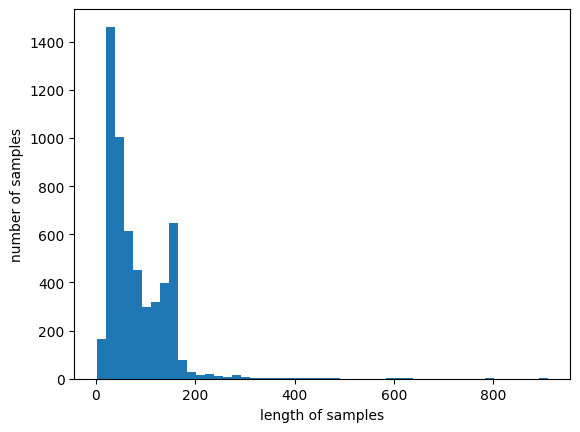

In [ ]:
print('메일의 최대 길이 : %d' % max(len(sample) for sample in X_train_encoded))
print('메일의 평균 길이 : %f' % (sum(map(len, X_train_encoded))/len(X_train_encoded)))
plt.hist([len(sample) for sample in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

**RNN으로 스팸 메일 분류하기**

In [ ]:
#다대일 구조의 RNN

In [ ]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

embedding_dim = 32
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_padded, y_train, epochs=4, batch_size=64, validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          252960    
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 255073 (996.38 KB)
Trainable params: 255073 (996.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/4
56/56 [==============================] - 22s 368ms/step - loss: 0.5449 - acc: 0.7422 - val_loss: 0.3920 - val_acc: 0.8789
Epoch 2/4
56/56 [==============================] - 13s 231ms/step - loss: 0.2998 - acc: 0.8856 - val_loss: 0.1669 - val_acc: 0.9608
Epoch 3/4
56/5

In [ ]:
X_test_encoded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_encoded, maxlen = max_len)
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test_padded, y_test)[1]))

35/35 [==============================] - 1s 22ms/step - loss: 0.0710 - acc: 0.9776

 테스트 정확도: 0.9776


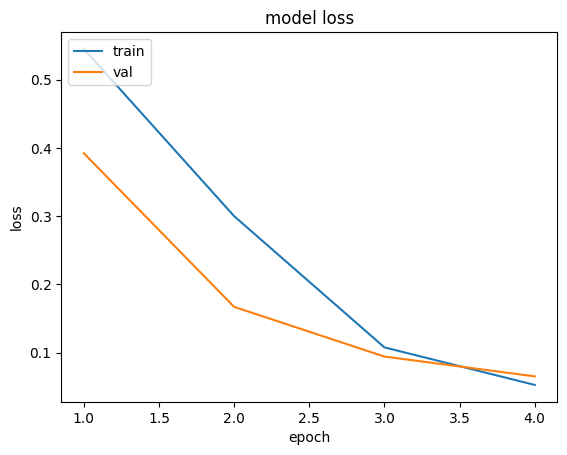

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# LSTM 간단한 예제

In [ ]:
#LSTM 기본 연습 코드(Tensorflow)
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler

# 예시 데이터 생성
def generate_data(n=500):
    x = np.arange(n)
    y = np.sin(0.02*x)
    return y.reshape(-1,1)

data = generate_data()

# 정규화
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

#시계열 데이터셋 만들기
def create_dataset(series, windows=20):
    X,y = [], []
    for i in range(len(series) - windows):
        X.append(series[i:i+windows])
        y.append(series[i+windows])
    return np.array(X), np.array(y)

window_size = 20 #window : batch_size
X,y = create_dataset(data_scaled,window_size)

# LSTM 입력 형태(batch_size(샘플의 수),timesteps(시간축 길이),feature(특징의 개수) 3D Tensor에 맞게 reshape
X = X.reshape((X.shape[0], X.shape[1],1))

# LSTM 구조 짜기
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(window_size,1)),
    Dense(32, activation='relu'),
    Dense(1)
])
# 길이 20짜리 1차원 시계열을 넣어서, 마지막 시점까지 본 LSTM hidden state 하나로 다음 값을 예측하는 many-to-one LSTM

model.compile(optimizer='adam',loss='mse')
model.summary()

#모델 학습
history = model.fit(X,y,epochs=20, batch_size=32,verbose=1)

#향후 30step 예측
preds = []
last_window = X[-1] #마지막 입력 시퀀스

current_window = last_window

for _ in range(30):
    pred = model.predict(current_window.reshape(1,window_size,1))
    preds.append(pred[0, 0])

    #window 업데이트
    current_window = np.vstack([current_window[1:], pred])

# 역정규화
preds = scaler.inverse_transform(np.array(preds).reshape(-1,1))
print("예측값 30개 : ", preds.flatten())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2386
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0223
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.4604e-04
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.0723e-04
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.1026e-04
Epoch 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

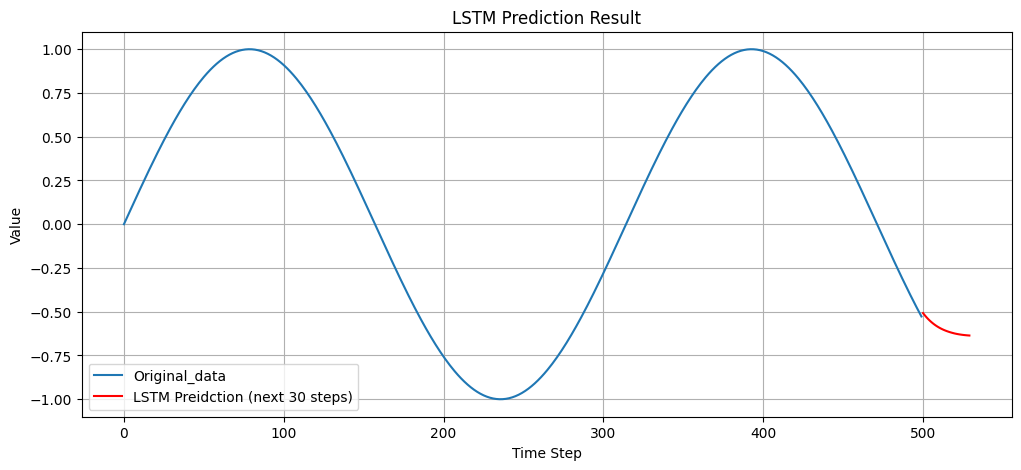

In [ ]:
import matplotlib.pyplot as plt

data_inv = scaler.inverse_transform(data_scaled)

#  예측 구간을 원래 시계열 뒤에 붙이기
full_plot = np.concatenate([data_inv.flatten(), preds.flatten()])

#x축
original_x = np.arange(len(data_inv))
pred_x = np.arange(len(data_inv), len(data_inv)+len(preds))

plt.figure(figsize=(12,5))
plt.plot(original_x, data_inv, label='Original_data')
plt.plot(pred_x, preds, label='LSTM Preidction (next 30 steps)', color='r')

plt.title('LSTM Prediction Result')
plt.xlabel('Time Step');plt.ylabel('Value')
plt.legend();plt.grid(True);plt.show()

X shape : (480, 20, 1)
y shape : (480, 20, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 20, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 1)          │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.2285
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0526
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0422
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0364
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0324
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0287
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0240
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0217
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0204
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0170
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0167
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0145
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0132
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0128
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0110
Epoch 16/20

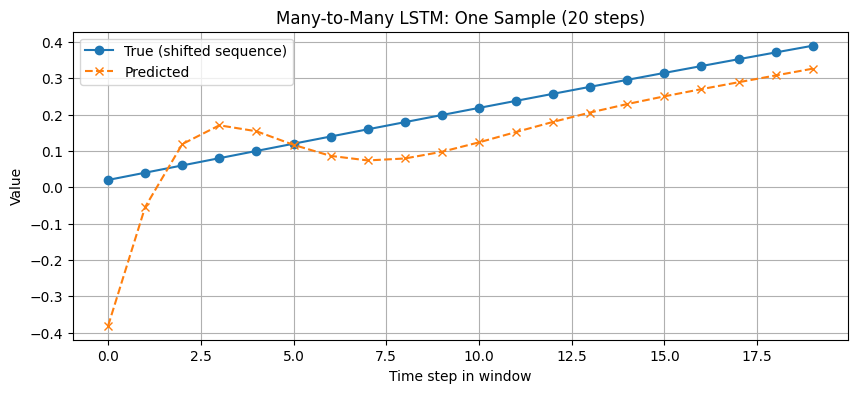

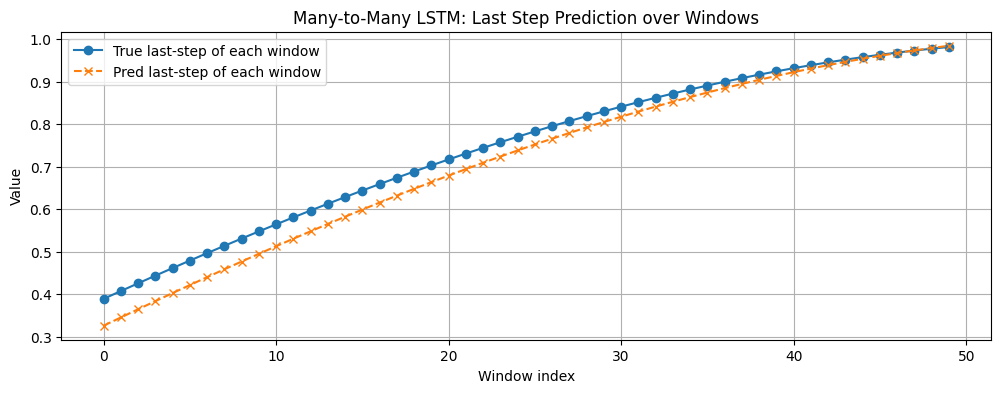

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
from sklearn.preprocessing import MinMaxScaler

# 1) 예시 데이터 생성 (sin 파형)
def generate_data(n=500):
    x = np.arange(n)
    y = np.sin(0.02 * x)
    return y.reshape(-1, 1)

data = generate_data()

# 2) 정규화
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 3) many-to-many용 시계열 데이터셋 만들기
#    X: [t, ..., t+19]
#    y: [t+1, ..., t+20]  (한 칸 뒤로 민 시퀀스)
def create_seq2seq_dataset(series, window=20):
    X, y = [], []
    for i in range(len(series) - window):
        x_seq = series[i : i + window]           # (window, 1)
        y_seq = series[i + 1 : i + window + 1]   # (window, 1)
        X.append(x_seq)
        y.append(y_seq)
    X = np.array(X)  # (samples, window, 1)
    y = np.array(y)  # (samples, window, 1)
    return X, y

window_size = 20
X, y = create_seq2seq_dataset(data_scaled, window_size)

print("X shape :", X.shape)  # (samples, 20, 1)
print("y shape :", y.shape)  # (samples, 20, 1)

# 4) LSTM many-to-many 모델 구성
model_seq2seq = Sequential([
    LSTM(32, activation='tanh', return_sequences=True, input_shape=(window_size, 1)),
    TimeDistributed(Dense(1))   # 각 time step마다 값 하나 예측
])

model_seq2seq.compile(optimizer='adam', loss='mse')
model_seq2seq.summary()

# 5) 모델 학습
history = model_seq2seq.fit(X, y, epochs=20, batch_size=32, verbose=1)

# 6) 예측 수행 (전체 시퀀스에 대해)
y_pred = model_seq2seq.predict(X)   # shape: (samples, 20, 1)

# 7) 첫 번째 샘플에 대해 "정답 vs 예측" 시각화
#    -> 눈으로 many-to-many 구조 확인
sample_idx = 0
true_seq = y[sample_idx]      # (20, 1) - 정답 (t+1 ~ t+20)
pred_seq = y_pred[sample_idx] # (20, 1) - 예측

# 역정규화
true_seq_inv = scaler.inverse_transform(true_seq)
pred_seq_inv = scaler.inverse_transform(pred_seq)

plt.figure(figsize=(10, 4))
plt.plot(true_seq_inv.flatten(), 'o-', label='True (shifted sequence)')
plt.plot(pred_seq_inv.flatten(), 'x--', label='Predicted')
plt.title("Many-to-Many LSTM: One Sample (20 steps)")
plt.xlabel("Time step in window")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# 8) 원래 시계열 위에 "예측 시퀀스" 일부를 겹쳐서 보기 (조금 더 직관용)
#    첫 50개 구간에 대해, y_pred를 이어 붙여 전체 곡선 느낌 보기
n_show = 50  # 앞쪽 샘플 몇 개만 사용할지
flat_true = []
flat_pred = []

for i in range(n_show):
    # 각 시퀀스의 마지막 값만 사용해서 이어 붙이면 "다음 값 예측" 느낌을 볼 수 있음
    flat_true.append(y[i, -1, 0])     # 정답 window의 마지막 값
    flat_pred.append(y_pred[i, -1, 0])# 예측 window의 마지막 값

flat_true = scaler.inverse_transform(np.array(flat_true).reshape(-1, 1)).flatten()
flat_pred = scaler.inverse_transform(np.array(flat_pred).reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 4))
plt.plot(flat_true, 'o-', label='True last-step of each window')
plt.plot(flat_pred, 'x--', label='Pred last-step of each window')
plt.title("Many-to-Many LSTM: Last Step Prediction over Windows")
plt.xlabel("Window index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


아래는 **“구조를 이해하기 위한” LSTM 3단계 실습**입니다.

- 공통 준비 코드
- 1단계: Stacked LSTM (다층 LSTM, `return_sequences` 이해)
- 2단계: Stateful LSTM (상태 유지 개념 체감)
- 3단계: LSTM vs GRU 비교 (구조 차이 감각 잡기)

각 단계는 **설명 → 실습 코드 → 시각화** 순서로 되어 있습니다.

In [ ]:
#공통 코드
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler

# 1) 예시 데이터 생성 (sin 파형)
def generate_data(n=500):
    x = np.arange(n)
    y = np.sin(0.02 * x)
    return y.reshape(-1, 1)  # (n, 1)

data = generate_data()

# 2) 정규화
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 3) 시계열 데이터셋 만들기 (many-to-one)
#    X: [t, ..., t+window-1]  -> y: t+window
def create_dataset(series, window=20):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i : i + window])      # (window, 1)
        y.append(series[i + window])          # (1,)
    X = np.array(X)                           # (samples, window, 1)
    y = np.array(y)                           # (samples, 1)
    return X, y

window_size = 20
X, y = create_dataset(data_scaled, window_size)

print("X shape:", X.shape)  # (samples, 20, 1)
print("y shape:", y.shape)  # (samples, 1)

# 4) 간단한 예측 시각화 함수 (마지막 step 예측을 전체에 겹쳐보기)
def plot_prediction(y_true_scaled, y_pred_scaled, title="Prediction"):
    """
    y_true_scaled, y_pred_scaled : (samples, 1) 형태, 스케일 된 값
    """
    y_true = scaler.inverse_transform(y_true_scaled).flatten()
    y_pred = scaler.inverse_transform(y_pred_scaled).flatten()

    plt.figure(figsize=(12, 4))
    plt.plot(y_true, 'o-', label='True')
    plt.plot(y_pred, 'x--', label='Predicted')
    plt.title(title)
    plt.xlabel("Sample index")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()
    plt.show()

X shape: (480, 20, 1)
y shape: (480, 1)


### LSTM 구조 이해를 위한 3단계 학습 흐름

---

**Stacked LSTM** (return_sequences 이해 + LSTM의 출력 구조 잡기)

- LSTM은 시간축 시퀀스를 입력으로 받고,
- 각 시점마다 hidden state를 계산한 뒤,
- 마지막 hidden state 또는 전체 hidden state sequence를 출력할 수 있다.

이때 어떤 출력을 다음 층으로 넘길지 결정하는 옵션이 **return_sequences**.


| 설정 | 출력 형태 | 사용 상황 |
|------|------------|-----------|
| `return_sequences=False` | (batch, units) | 마지막 시점만 사용 (many-to-one) |
| `return_sequences=True` | (batch, timesteps, units) | 전체 시점의 정보를 다음 층으로 넘김 (many-to-many, stacked LSTM) |

**Stacked LSTM**을 만들 때는 아래층이 반드시 `return_sequences=True`여야 한다.

---

**1.3 Stacked LSTM 구조 예시**

    입력(20 step)

    ↓

    [LSTM 32 units, return_sequences=True]

    ↓ (전체 시퀀스 출력)

    [LSTM 16 units, return_sequences=False]

    ↓ (마지막 state)

    [Dense → Dense → 출력]



Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3605
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0384
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0161
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0112
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0064
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029
Epoch 16/20
15/15 ━━━━━━━━━

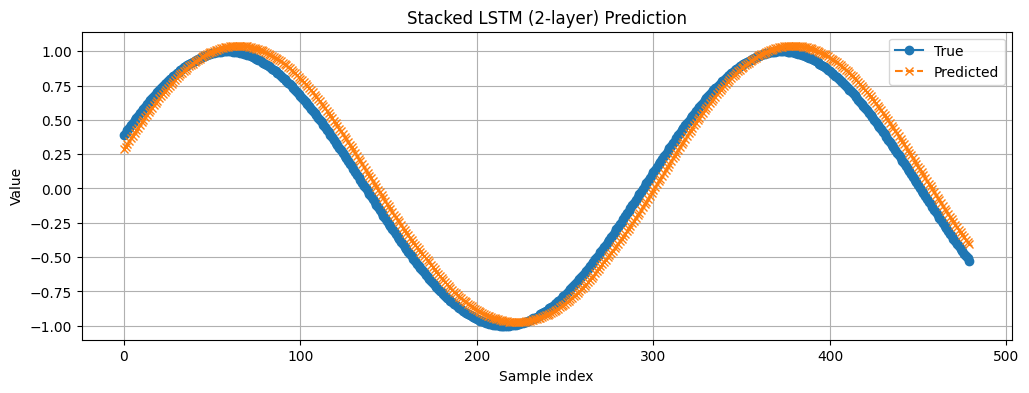

In [ ]:
model_stacked = Sequential([
    LSTM(32, activation='tanh', return_sequences=True, input_shape=(window_size, 1)), #stacked LSTM에서 return_sequences=True는 필수.
    LSTM(16, activation='tanh', return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)
])

model_stacked.compile(optimizer='adam', loss='mse')
history_stacked = model_stacked.fit(X, y, epochs=20, batch_size=32)
y_pred_stacked = model_stacked.predict(X)
plot_prediction(y, y_pred_stacked, "Stacked LSTM (2-layer) Prediction")

**Stateful LSTM (상태 유지 개념 체감)**


- 기본 LSTM (`stateful=False`)
  - 각 미니배치가 끝날 때마다 hidden state $h_t$, cell state $c_t$가 **초기화**된다.
  - 배치 사이에는 “기억”이 이어지지 않는다.

- Stateful LSTM (`stateful=True`)
  - 한 배치의 마지막 state가 **다음 배치의 초기 state로 전달**된다.
  - 긴 시퀀스를 여러 배치로 잘라 학습하면서도, 내부 상태는 **연속된 흐름**으로 유지 가능하다.

---

**사용할 때의 필수 조건**

1. `batch_input_shape=(batch_size, timesteps, features)`  
   - `input_shape` 대신 반드시 **batch 크기까지 포함한 입력 형태**를 지정해야 한다.
2. `fit(..., shuffle=False)`  
   - 데이터 순서를 섞으면 “이전 배치의 state가 전혀 다른 시퀀스에 전달되는” 문제가 생긴다.
3. `model.reset_states()`  
   - epoch를 새로 시작할 때 등, 상태를 끊고 싶을 때 **명시적으로 초기화**한다.

---
실습: 간단 Stateful LSTM 예제

- 같은 sin 시계열을 사용하되,
- `stateful=True`로 두고 여러 epoch를 돌린 뒤,
- 예측 결과를 그림으로 확인한다.


usable samples: 480


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (32, 32)               │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (32, 16)               │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (32, 1)                │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,897 (19.13 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)


[Stateful LSTM] Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4846

[Stateful LSTM] Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0673

[Stateful LSTM] Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094

[Stateful LSTM] Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0120

[Stateful LSTM] Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046

[Stateful LSTM] Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044

[Stateful LSTM] Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025

[Stateful LSTM] Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022

[Stateful LSTM] Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014

[Stateful LSTM] Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


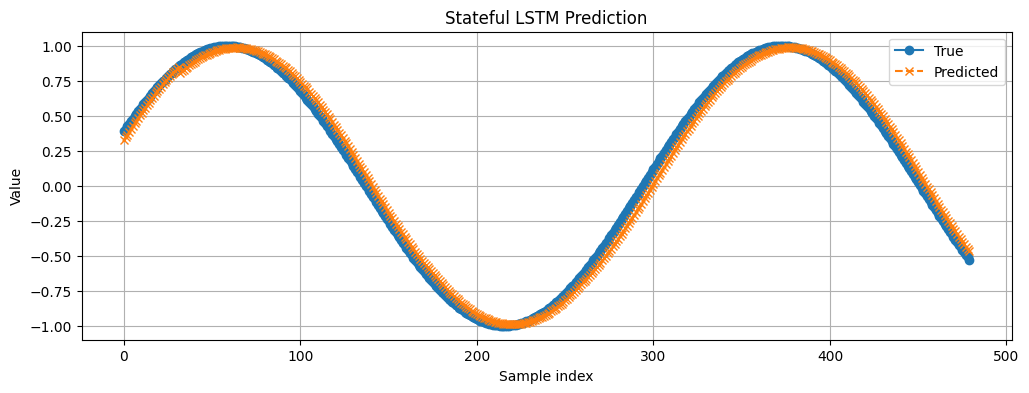

In [ ]:
# ---------- 2단계: Stateful LSTM ----------

# batch_size를 samples 수에 맞게 나누기 좋게 설정
batch_size = 32
n_samples = X.shape[0]

# batch_size로 나누어 떨어지게 앞부분만 사용
usable_n = (n_samples // batch_size) * batch_size

X_stateful = X[:usable_n]
y_stateful = y[:usable_n]

print("usable samples:", usable_n)

# Keras 3 스타일: Input 층에서 batch_shape 지정
# Keras 3 스타일: Input 층에서 batch_shape 지정
model_stateful = Sequential([
    Input(batch_shape=(batch_size, window_size, 1)),
    LSTM(
        32,
        activation="tanh",
        stateful=True,
        return_sequences=False,
    ),
    Dense(16, activation="relu"),
    Dense(1),
])

model_stateful.compile(optimizer="adam", loss="mse")
model_stateful.summary()

epochs = 10

for e in range(epochs):
    print(f"\n[Stateful LSTM] Epoch {e+1}/{epochs}")
    model_stateful.fit(
        X_stateful,
        y_stateful,
        epochs=1,
        batch_size=batch_size,
        shuffle=False,   # 순서 유지 필수
        verbose=1,
    )
    # 다음 epoch 시작 전에 state 초기화 (모든 stateful 레이어에 적용)
    for layer in model_stateful.layers:
        if hasattr(layer, "reset_states"):
            layer.reset_states()

# 예측 시에도 batch_size를 맞춰야 함
y_pred_stateful = model_stateful.predict(
    X_stateful,
    batch_size=batch_size
)

plot_prediction(y_stateful, y_pred_stateful, title="Stateful LSTM Prediction")

In [ ]:
# ============================================
# 셀 1. 준비: 라이브러리 / 함수 정의
# ============================================
import numpy as np
import tensorflow as tf

np.random.seed(0)
tf.random.set_seed(0)

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def lstm_step_np(x_t, h_prev, c_prev, W, U, b):
    """
    NumPy로 구현한 LSTM 한 스텝
    게이트 순서: [i, f, g, o]
    x_t   : (batch_size, input_dim)
    h_prev: (batch_size, hidden_dim)
    c_prev: (batch_size, hidden_dim)
    W     : (input_dim, 4*hidden_dim)
    U     : (hidden_dim, 4*hidden_dim)
    b     : (4*hidden_dim,)
    """
    # 선형 결합
    z = x_t @ W + h_prev @ U + b  # (batch_size, 4*hidden_dim)

    # 4개 gate로 split (i, f, g, o)  ← Keras LSTMCell과 동일한 순서
    i, f, g, o = np.split(z, 4, axis=1)

    # 활성 함수
    i = sigmoid(i)       # input gate
    f = sigmoid(f)       # forget gate
    g = np.tanh(g)       # cell candidate
    o = sigmoid(o)       # output gate

    # cell / hidden 업데이트
    c_t = f * c_prev + i * g
    h_t = o * np.tanh(c_t)

    cache = {
        "i": i,
        "f": f,
        "g": g,
        "o": o,
        "c": c_t,
        "h": h_t,
    }
    return h_t, c_t, cache



In [ ]:
# ============================================
# 셀 2. NumPy LSTM과 tf.keras LSTMCell을
#       동일한 weight로 세팅
# ============================================

# 하이퍼파라미터
batch_size = 1
input_dim = 3
hidden_dim = 2
T = 5  # 시퀀스 길이

# NumPy로 weight 초기화 (float32로 맞춰줌)
W_np = (np.random.randn(input_dim, 4 * hidden_dim) * 0.1).astype(np.float32)
U_np = (np.random.randn(hidden_dim, 4 * hidden_dim) * 0.1).astype(np.float32)
b_np = np.zeros(4 * hidden_dim, dtype=np.float32)

# 입력 시퀀스 (batch_size, T, input_dim)
X_np = np.random.randn(batch_size, T, input_dim).astype(np.float32)

# 초기 state
h_np = np.zeros((batch_size, hidden_dim), dtype=np.float32)
c_np = np.zeros((batch_size, hidden_dim), dtype=np.float32)

# ---- TensorFlow LSTMCell 생성 및 weight 맞추기 ----
cell = tf.keras.layers.LSTMCell(
    units=hidden_dim,
    use_bias=True
)

# build를 먼저 해서 weight 생성
cell.build(input_shape=(batch_size, input_dim))

# Keras의 kernel / recurrent_kernel / bias에 NumPy weight를 그대로 복사
cell.kernel.assign(W_np)            # (input_dim, 4*hidden_dim)
cell.recurrent_kernel.assign(U_np)  # (hidden_dim, 4*hidden_dim)
cell.bias.assign(b_np)              # (4*hidden_dim,)

# TF 쪽 state 초기화
h_tf = tf.zeros((batch_size, hidden_dim), dtype=tf.float32)
c_tf = tf.zeros((batch_size, hidden_dim), dtype=tf.float32)

print("NumPy / TF LSTMCell 모두 같은 weight로 설정 완료")
print("W shape:", W_np.shape, "U shape:", U_np.shape, "b shape:", b_np.shape)


NumPy / TF LSTMCell 모두 같은 weight로 설정 완료
W shape: (3, 8) U shape: (2, 8) b shape: (8,)


In [ ]:
# ============================================
# 셀 3. 시퀀스 전체를 흘려보내면서
#       NumPy LSTM과 tf.keras LSTMCell 결과 비교
#       + gate 값도 출력
# ============================================

for t in range(T):
    # 현재 시점 입력
    x_t_np = X_np[:, t, :]  # (batch_size, input_dim)

    # ----- NumPy 버전 LSTM 한 스텝 -----
    h_np, c_np, cache = lstm_step_np(x_t_np, h_np, c_np, W_np, U_np, b_np)

    # ----- TensorFlow LSTMCell 한 스텝 -----
    x_t_tf = tf.convert_to_tensor(x_t_np)  # (batch_size, input_dim)
    output_tf, [h_tf, c_tf] = cell(x_t_tf, states=[h_tf, c_tf])
    # output_tf == h_tf (LSTMCell의 output은 곧 hidden state)

    # ----- 검증: 두 구현이 수치적으로 같은지 확인 -----
    diff_h = np.max(np.abs(h_np - h_tf.numpy()))
    diff_c = np.max(np.abs(c_np - c_tf.numpy()))

    print(f"====== time step {t} ======")
    print("x_t:", x_t_np)
    print("NumPy i (input gate):", cache["i"])
    print("NumPy f (forget gate):", cache["f"])
    print("NumPy g (cell cand)  :", cache["g"])
    print("NumPy o (output gate):", cache["o"])
    print("NumPy c_t:", cache["c"])
    print("NumPy h_t:", cache["h"])
    print("TF   h_t:", h_tf.numpy())
    print("TF   c_t:", c_tf.numpy())
    print("max |h_np - h_tf| =", diff_h)
    print("max |c_np - c_tf| =", diff_c)

    # allclose 여부도 표시
    print("h 동일? :", np.allclose(h_np, h_tf.numpy(), atol=1e-6))
    print("c 동일? :", np.allclose(c_np, c_tf.numpy(), atol=1e-6))
    print()

====== time step 0 ======
x_t: [[-1.048553  -1.420018  -1.7062702]]
NumPy i (input gate): [[0.39526278 0.4836911 ]]
NumPy f (forget gate): [[0.45598963 0.42659745]]
NumPy g (cell cand)  : [[ 0.13096046 -0.02632421]]
NumPy o (output gate): [[0.42307878 0.5237625 ]]
NumPy c_t: [[ 0.0517638  -0.01273278]]
NumPy h_t: [[ 0.02188062 -0.00666859]]
TF   h_t: [[ 0.02188062 -0.0066686 ]]
TF   c_t: [[ 0.05176379 -0.01273279]]
max |h_np - h_tf| = 3.7252903e-09
max |c_np - c_tf| = 3.7252903e-09
h 동일? : True
c 동일? : True

====== time step 1 ======
x_t: [[ 1.9507754 -0.5096522 -0.4380743]]
NumPy i (input gate): [[0.5718723 0.5160599]]
NumPy f (forget gate): [[0.54244906 0.59867144]]
NumPy g (cell cand)  : [[ 0.41356608 -0.21943864]]
NumPy o (output gate): [[0.53132087 0.49675238]]
NumPy c_t: [[ 0.2645862  -0.12086623]]
NumPy h_t: [[ 0.13738903 -0.05974992]]
TF   h_t: [[ 0.13738903 -0.0597499 ]]
TF   c_t: [[ 0.2645862  -0.12086621]]
max |h_np - h_tf| = 1.4901161e-08
max |c_np - c_tf| = 2.2351742e-08
h

## 3단계. LSTM vs GRU 비교 (구조 차이 감 잡기)

### 3.1 LSTM 구조

- 게이트 3개:
  - Forget gate
  - Input gate
  - Output gate
- 상태 2개:
  - Cell state \(c_t\): 장기 기억
  - Hidden state \(h_t\): 출력 겸 단기 상태

→ 더 정교한 제어, 더 많은 파라미터, 계산량도 상대적으로 큼.

---

### 3.2 GRU 구조

- 게이트 2개:
  - Reset gate
  - Update gate
- 상태 1개:
  - Hidden state \(h_t\)만 사용 (cell state 없음)
- 구조 단순화 → 파라미터 수 적고, **계산이 빠른 경우가 많음**.

---

### 3.3 LSTM vs GRU 실습 개념

- 동일한 데이터(X, y), 동일한 조건(epoch, batch_size)에서
  - LSTM 모델
  - GRU 모델
  을 각각 학습시키고,
- 아래 3가지를 비교한다:
  1. training loss 곡선
  2. 예측 곡선(원래 sin 파형과 비교)
  3. 학습 속도/수렴 느낌

이를 통해 “LSTM과 GRU가 구조는 다르지만,  
실제로는 **비슷한 수준의 시계열 패턴을 학습할 수 있다는 것**”을 감각적으로 이해할 수 있다.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


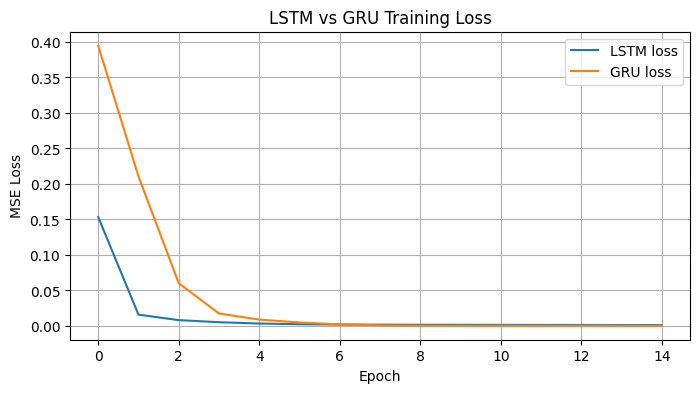

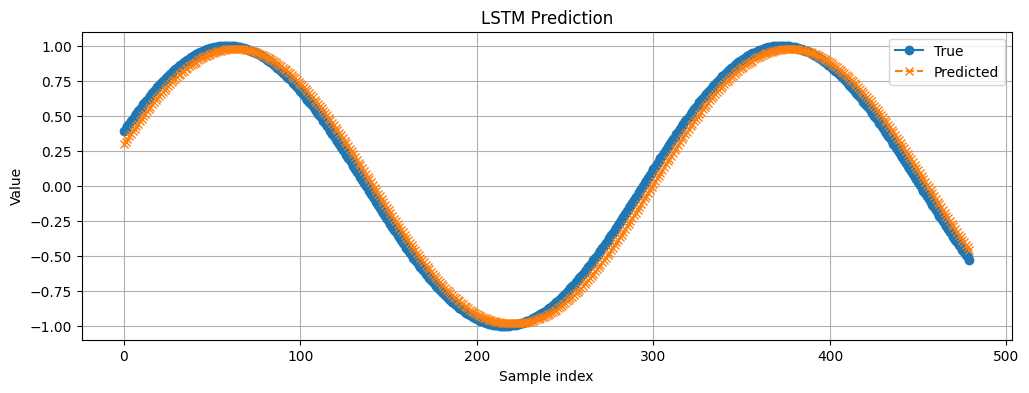

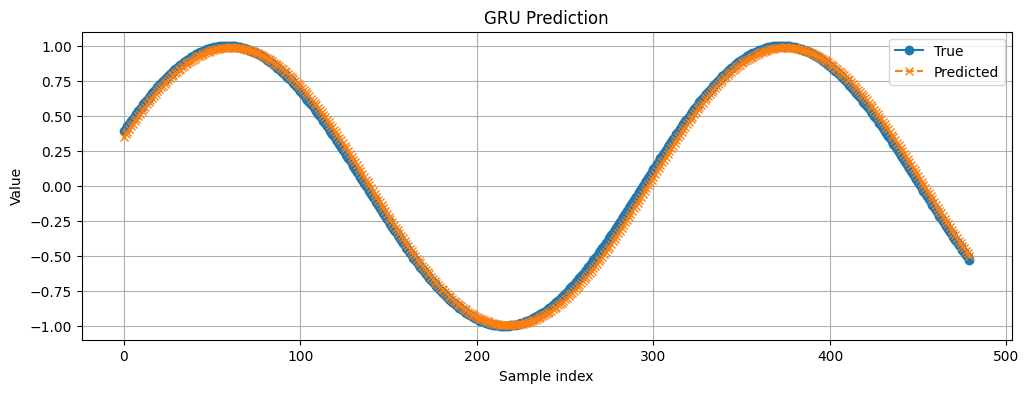

LSTM MSE: 0.001107
GRU  MSE: 0.000284


In [ ]:
# 재초기화 (seed)
tf.random.set_seed(0)
np.random.seed(0)

# --- LSTM 모델 ---
model_lstm = Sequential([
    LSTM(32, activation="tanh", input_shape=(window_size, 1)),
    Dense(16, activation="relu"),
    Dense(1),
])

model_lstm.compile(optimizer="adam", loss="mse")

history_lstm = model_lstm.fit(
    X,
    y,
    epochs=15,
    batch_size=32,
    verbose=0,
)

y_pred_lstm = model_lstm.predict(X, verbose=0)


# --- GRU 모델 ---
model_gru = Sequential([
    GRU(32, activation="tanh", input_shape=(window_size, 1)),
    Dense(16, activation="relu"),
    Dense(1),
])

model_gru.compile(optimizer="adam", loss="mse")

history_gru = model_gru.fit(
    X,
    y,
    epochs=15,
    batch_size=32,
    verbose=0,
)

y_pred_gru = model_gru.predict(X, verbose=0)

# ============================
# 5. 학습 곡선 비교
# ============================
plt.figure(figsize=(8, 4))
plt.plot(history_lstm.history["loss"], label="LSTM loss")
plt.plot(history_gru.history["loss"], label="GRU loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("LSTM vs GRU Training Loss")
plt.grid(True)
plt.legend()
plt.show()

# ============================
# 6. 예측 결과 비교
# ============================
plot_prediction(y, y_pred_lstm, title="LSTM Prediction")
plot_prediction(y, y_pred_gru, title="GRU Prediction")

# ============================
# 7. MSE 수치 비교
# ============================
from sklearn.metrics import mean_squared_error

mse_lstm = mean_squared_error(y, y_pred_lstm)
mse_gru = mean_squared_error(y, y_pred_gru)

print(f"LSTM MSE: {mse_lstm:.6f}")
print(f"GRU  MSE: {mse_gru:.6f}")

### LSTM으로 IMDB 리뷰 감성 분류 하기

- Packages

In [ ]:
from tensorflow.keras.datasets import imdb
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
(X_train,y_train), (X_test,y_test) = imdb.load_data()

17464789/17464789 [==============================] - 0s 0us/step


In [ ]:
print(len(X_train))    #트레인 세트의 크기     #25000
print(len(X_test))     #테스트 세트의 크기     #25000
print(max(y_train)+1)  #트레인 세트 라벨 크기  #2
print(y_train[0])      #첫번째 트레인 세트 라벨 이름 #1
print(y_train[1])      #두번째 트레인 세트 라벨 이름 #0
print(X_train[0])      #첫번째 데이터 내용

25000
25000
2
1
0
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


- 이미 전처리가 되어 있는 모습

In [ ]:
#각 리뷰 안에 최대 길이 리뷰와 전체 리뷰의 평균 길이를 확인

In [ ]:
len_result = [len(s) for s in X_train]
print(np.max(len_result))
print(np.mean(len_result))

2494
238.71364


- Bulid model

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# 전체 데이터에 대해서 작업하는데 시간이 많이 소요되므로 사용 빈도수가 높은 5000개의 단어만 가져옴.
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

In [ ]:
# 최대가 2494, 평균 길이가 236.7이니 대충 500정도에서 잘라주자.그것과 패딩일 실시
max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
#이진 분류이기 때문에 sigmoid
model = Sequential()
model.add(Embedding(5000, 120))
model.add(LSTM(120))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history=model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=20, batch_size=64)

Epoch 1/20
391/391 [==============================] - 663s 2s/step - loss: 0.4614 - acc: 0.7801 - val_loss: 0.3635 - val_acc: 0.8430
Epoch 2/20
391/391 [==============================] - 581s 1s/step - loss: 0.3611 - acc: 0.8390 - val_loss: 0.4001 - val_acc: 0.8265
Epoch 3/20
391/391 [==============================] - 586s 2s/step - loss: 0.3866 - acc: 0.8347 - val_loss: 0.3786 - val_acc: 0.8470
Epoch 4/20
391/391 [==============================] - 640s 2s/step - loss: 0.2712 - acc: 0.8913 - val_loss: 0.3740 - val_acc: 0.8531
Epoch 5/20
391/391 [==============================] - 578s 1s/step - loss: 0.2195 - acc: 0.9142 - val_loss: 0.3362 - val_acc: 0.8592
Epoch 6/20
391/391 [==============================] - 580s 1s/step - loss: 0.2018 - acc: 0.9255 - val_loss: 0.3460 - val_acc: 0.8655
Epoch 7/20
391/391 [==============================] - 584s 1s/step - loss: 0.1511 - acc: 0.9453 - val_loss: 0.3708 - val_acc: 0.8577
Epoch 8/20
391/391 [==============================] - 580s 1s/step - 

In [ ]:
#Analysis
scores = model.evaluate(X_test, y_test)
print('acc: %.4ff%%'% (scores[1]*100))

782/782 [==============================] - 7s 9ms/step - loss: 0.7119 - acc: 0.8471
acc: 84.7080f%


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

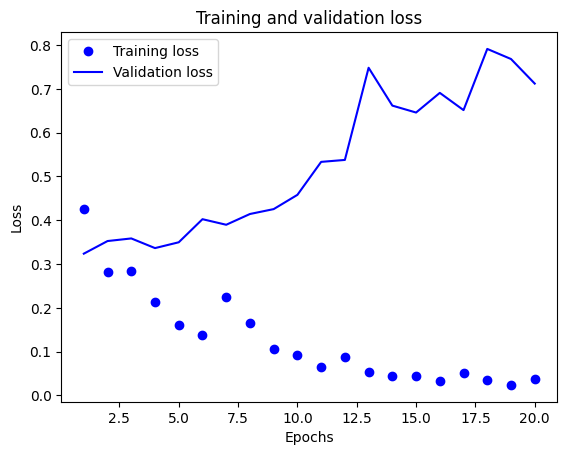

In [ ]:
import matplotlib.pyplot as plt

loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs=range(1, len(history_dict['acc'])+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

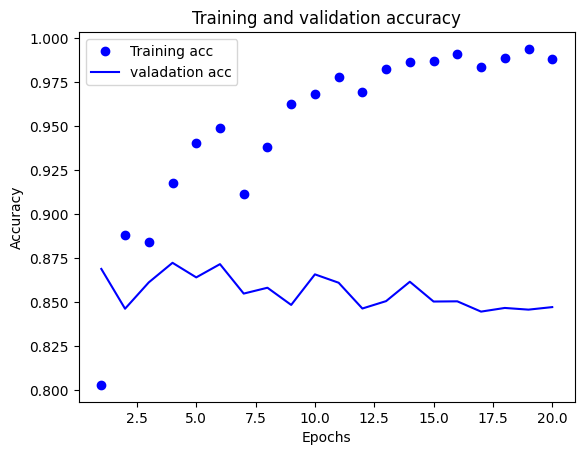

In [ ]:
plt.clf()

plt.plot(epochs, history_dict['acc'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_acc'], 'b', label= 'valadation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 로이터 뉴스 분류하기(Reuters News Classification)

- 로이터 뉴스 기사 데이터는 총 11,258개의 뉴스 기사가 46개의 뉴스 카테고리로 분류되는 뉴스 기사 데이터

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters

- num_words는 이 데이터에서 등장 빈도 순위로 몇 번째에 해당하는 단어까지만 사용할 것인지 조절
    - 지금은 모든 단어를 사용하자.

In [ ]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

print('훈련용 뉴스 기사 : {}'.format(len(X_train)))
print('테스트용 뉴스 기사 : {}'.format(len(X_test)))
num_classes = len(set(y_train))
print('카테고리 : {}'.format(num_classes))

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
훈련용 뉴스 기사 : 8982
테스트용 뉴스 기사 : 2246
카테고리 : 46


In [ ]:
print('첫번째 훈련용 뉴스 기사 :',X_train[0])
print('첫번째 훈련용 뉴스 기사의 레이블 :',y_train[0])

첫번째 훈련용 뉴스 기사 : [1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
첫번째 훈련용 뉴스 기사의 레이블 : 3


- 이 데이터는 토큰화와 정수 인코딩(각 단어를 정수로 변환)이 끝난 상태

뉴스 기사의 최대 길이 :2376
뉴스 기사의 평균 길이 :145.5398574927633


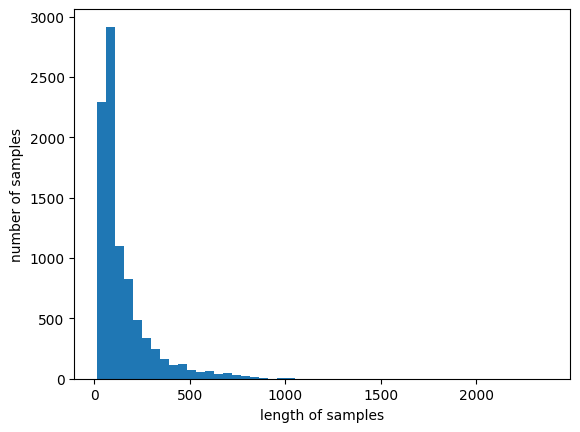

In [ ]:
print('뉴스 기사의 최대 길이 :{}'.format(max(len(sample) for sample in X_train)))
print('뉴스 기사의 평균 길이 :{}'.format(sum(map(len, X_train))/len(X_train)))

plt.hist([len(sample) for sample in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

<Axes: ylabel='count'>

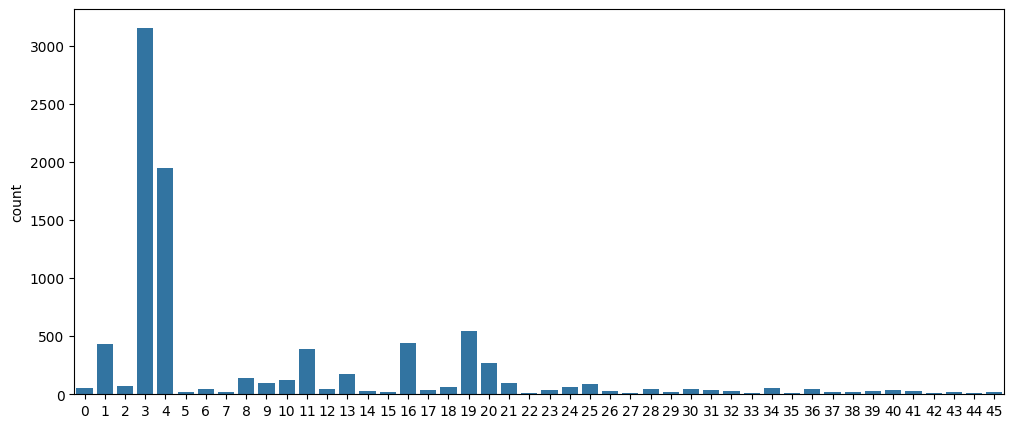

In [ ]:
#각 뉴스의 레이블 값의 분포
fig, axe = plt.subplots()
fig.set_size_inches(12,5)
sns.countplot(x=y_train)

- 3,4가 가장 많은 레이블을 차지하는 것은 확인할 수 있음.

In [ ]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


- 3번 레이블은 총 3,159개가 존재하고 4번 레이블은 총 1,949개가 존재하는 것을 확인할 수 있음.

In [ ]:
word_to_index = reuters.get_word_index()
print(word_to_index)

550378/550378 ━━━━━━━━━━━━━━━━━━━━ 1s 2us/step
{'mdbl': 10996, 'fawc': 16260, 'degussa': 12089, 'woods': 8803, 'hanging': 13796, 'localized': 20672, 'sation': 20673, 'chanthaburi': 20675, 'refunding': 10997, 'hermann': 8804, 'passsengers': 20676, 'stipulate': 20677, 'heublein': 8352, 'screaming': 20713, 'tcby': 16261, 'four': 185, 'grains': 1642, 'broiler': 20680, 'wooden': 12090, 'wednesday': 1220, 'highveld': 13797, 'duffour': 7593, '0053': 20681, 'elections': 3914, '270': 2563, '271': 3551, '272': 5113, '273': 3552, '274': 3400, 'rudman': 7975, '276': 3401, '277': 3478, '278': 3632, '279': 4309, 'dormancy': 9381, 'errors': 7247, 'deferred': 3086, 'sptnd': 20683, 'cooking': 8805, 'stratabit': 20684, 'designing': 16262, 'metalurgicos': 20685, 'databank': 13798, '300er': 20686, 'shocks': 20687, 'nawg': 7972, 'tnta': 20688, 'perforations': 20689, 'affiliates': 2891, '27p': 20690, 'ching': 16263, 'china': 595, 'wagyu': 16264, 'affiliated': 3189, 'chino': 16265, 'chinh': 16266, 'slickline

- 정수로부터 단어를 알 수 있도록 해보자.


-  word_to_index에서 key와 value를 반대로 저장한 index_to_word를 만듭니다. 주의할 점은 reuters.get_word_index()에 저장된 값에 +3을 해야 실제 맵핑되는 정수입니다. 이것은 로이터 뉴스 데이터셋에서 정한 규칙입니다.

In [ ]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value+3] = key

In [ ]:
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[4])) # +3을 했으므로 빈도수 1등에 해당하는 단어를 알고 싶다면 숫자 4를 넣어야 함.

빈도수 상위 1번 단어 : the


In [ ]:
print('빈도수 상위 128등 단어 : {}'.format(index_to_word[131]))

빈도수 상위 128등 단어 : tax


- index_to_word에서 숫자 0은 패딩을 의미하는 토큰인 pad, 숫자 1은 문장의 시작을 의미하는 sos, 숫자 2는 OOV(Out of Vocabulary)를 위한 토큰인 unk(Unknoiwn token)라는 특별 토큰에 맵핑

In [ ]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index] = token

print(' '.join([index_to_word[index] for index in X_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


**LSTM으로 로이터 뉴스 분류하기**

In [ ]:
#등장 빈도 순위 상위 1000개의 단어들만 사용.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

vocab_size = 1000
max_len = 100
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=vocab_size, test_split=0.2)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
#다대일 구조의 LSTM

In [ ]:
embedding_dim = 128
hidden_units = 128
num_classes = 46

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(X_test, y_test))

Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.3282 - loss: 2.9295
Epoch 1: val_acc improved from -inf to 0.46839, saving model to best_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - acc: 0.3288 - loss: 2.9241 - val_acc: 0.4684 - val_loss: 2.1529
Epoch 2/30
67/71 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.4768 - loss: 2.1063
Epoch 2: val_acc improved from 0.46839 to 0.50668, saving model to best_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.4772 - loss: 2.1040 - val_acc: 0.5067 - val_loss: 2.0187
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.5195 - loss: 1.9428
Epoch 3: val_acc improved from 0.50668 to 0.55699, saving model to best_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.5196 - loss: 1.9422 - val_acc: 0.5570 - val_loss: 1.8255
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.5642 - loss: 1.7111
Epoch 4: val_acc did not improve from 0.55699
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.5642 - loss: 1.7108 - val_acc: 0.5552 - val_loss: 1.7185
Epoch 5/30
66/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.5852 - loss: 1.6203
Epoch 5: val_acc improved from 0.55699 to 0.60419, saving model to best_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.5861 - loss: 1.6181 - val_acc: 0.6042 - val_loss: 1.5937
Epoch 6/30
67/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.6159 - loss: 1.5007
Epoch 6: val_acc improved from 0.60419 to 0.62199, saving model to best_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.6167 - loss: 1.4985 - val_acc: 0.6220 - val_loss: 1.5120
Epoch 7/30
66/71 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.6339 - loss: 1.4207
Epoch 7: val_acc improved from 0.62199 to 0.63313, saving model to best_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.6349 - loss: 1.4180 - val_acc: 0.6331 - val_loss: 1.4487
Epoch 8/30
66/71 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.6609 - loss: 1.3281
Epoch 8: val_acc improved from 0.63313 to 0.64871, saving model to best_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.6615 - loss: 1.3267 - val_acc: 0.6487 - val_loss: 1.3911
Epoch 9/30
67/71 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.6829 - loss: 1.2613
Epoch 9: val_acc improved from 0.64871 to 0.65583, saving model to best_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.6834 - loss: 1.2602 - val_acc: 0.6558 - val_loss: 1.3341
Epoch 10/30
67/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.6946 - loss: 1.2057
Epoch 10: val_acc improved from 0.65583 to 0.66474, saving model to best_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.6951 - loss: 1.2048 - val_acc: 0.6647 - val_loss: 1.3058
Epoch 11/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.7084 - loss: 1.1410
Epoch 11: val_acc did not improve from 0.66474
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.7085 - loss: 1.1409 - val_acc: 0.6585 - val_loss: 1.2959
Epoch 12/30
66/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.7226 - loss: 1.0898
Epoch 12: val_acc improved from 0.66474 to 0.68299, saving model to best_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.7234 - loss: 1.0878 - val_acc: 0.6830 - val_loss: 1.2435
Epoch 13/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.7451 - loss: 1.0249
Epoch 13: val_acc improved from 0.68299 to 0.70169, saving model to best_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.7452 - loss: 1.0246 - val_acc: 0.7017 - val_loss: 1.1950
Epoch 14/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.7603 - loss: 0.9698
Epoch 14: val_acc improved from 0.70169 to 0.70258, saving model to best_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - acc: 0.7604 - loss: 0.9695 - val_acc: 0.7026 - val_loss: 1.1848
Epoch 15/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.7733 - loss: 0.9152
Epoch 15: val_acc did not improve from 0.70258
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.7733 - loss: 0.9149 - val_acc: 0.7004 - val_loss: 1.1892
Epoch 16/30
67/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.7780 - loss: 0.8796
Epoch 16: val_acc did not improve from 0.70258
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.7788 - loss: 0.8776 - val_acc: 0.6981 - val_loss: 1.2017
Epoch 17/30
66/71 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.7847 - loss: 0.8533
Epoch 17: val_acc improved from 0.70258 to 0.71416, saving model to best_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.7858 - loss: 0.8505 - val_acc: 0.7142 - val_loss: 1.1668
Epoch 18/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.8013 - loss: 0.7832
Epoch 18: val_acc improved from 0.71416 to 0.72262, saving model to best_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.8014 - loss: 0.7829 - val_acc: 0.7226 - val_loss: 1.1859
Epoch 19/30
66/71 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.8141 - loss: 0.7476
Epoch 19: val_acc did not improve from 0.72262
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.8147 - loss: 0.7457 - val_acc: 0.7204 - val_loss: 1.1912
Epoch 20/30
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.8200 - loss: 0.7170
Epoch 20: val_acc improved from 0.72262 to 0.72395, saving model to best_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.8202 - loss: 0.7164 - val_acc: 0.7240 - val_loss: 1.1903
Epoch 21/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.8261 - loss: 0.6933
Epoch 21: val_acc improved from 0.72395 to 0.72440, saving model to best_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.8262 - loss: 0.6929 - val_acc: 0.7244 - val_loss: 1.1992
Epoch 21: early stopping


In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.7398 - loss: 1.1602

 테스트 정확도: 0.7244


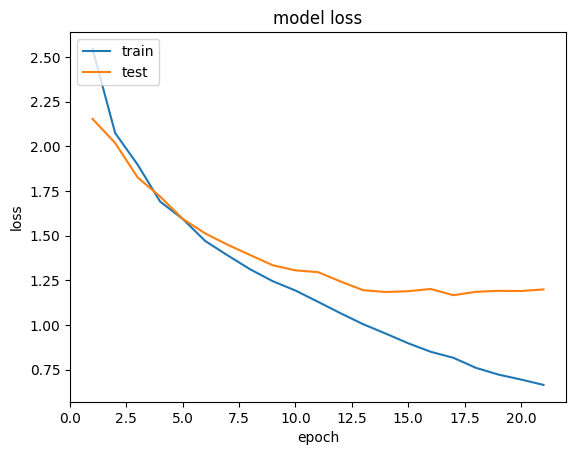

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

- IMDB 리뷰 데이터

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb

In [ ]:
(X_train, y_train), (X_test, y_test) = imdb.load_data()

print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))
num_classes = len(set(y_train))
print('카테고리 : {}'.format(num_classes))

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000
카테고리 : 2


In [ ]:
print('첫번째 훈련용 리뷰 :',X_train[0])
print('첫번째 훈련용 리뷰의 레이블 :',y_train[0])

첫번째 훈련용 리뷰 : [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
첫번째 훈련용 리뷰의 레이블 : 1


리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


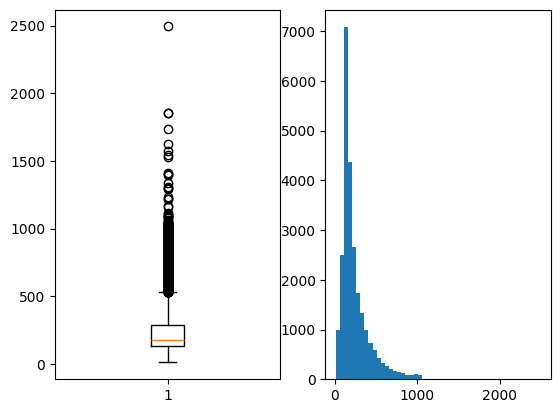

In [ ]:
reviews_length = [len(review) for review in X_train]

print('리뷰의 최대 길이 : {}'.format(np.max(reviews_length)))
print('리뷰의 평균 길이 : {}'.format(np.mean(reviews_length)))

plt.subplot(1,2,1)
plt.boxplot(reviews_length)
plt.subplot(1,2,2)
plt.hist(reviews_length, bins=50)
plt.show()

In [ ]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[    0     1]
 [12500 12500]]


In [ ]:
word_to_index = imdb.get_word_index()
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value+3] = key

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


In [ ]:
print('빈도수 상위 1등 단어 : {}'.format(index_to_word[4]))

빈도수 상위 1등 단어 : the


In [ ]:
print('빈도수 상위 3938등 단어 : {}'.format(index_to_word[3941]))

빈도수 상위 3938등 단어 : suited


In [ ]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index] = token

print(' '.join([index_to_word[index] for index in X_train[0]]))

<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shoul

### GRU로 IMDB 리뷰 감성 분류하기

단어 집합의 크기를 10,000으로 제한하고, 리뷰 최대 길이는 500으로 제한하여 패딩을 진행합니다.

In [ ]:
import re
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

vocab_size = 10000
max_len = 500

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

- hyperparameter
    - Embedding dimension :100
    - hidden_state 크기 : 128
- 모델은 다 대 일 구조의 GRU

- EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)는 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 정해진 epoch가 도달하지 못하였더라도, 학습을 조기 종료(Early Stopping)한다는 의미.

- ModelCheckPoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장.

In [ ]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('GRU_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
#.h5, .hdf5 / Hierarchical Data Format(HDF)의 파일 확장자.

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)
# model.save('GPU_model.h5')
# model.load('GPU_mode.h5')

Epoch 1/15
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.5920 - loss: 0.6565
Epoch 1: val_acc improved from -inf to 0.79340, saving model to GRU_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - acc: 0.5929 - loss: 0.6558 - val_acc: 0.7934 - val_loss: 0.5364
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.8093 - loss: 0.4265
Epoch 2: val_acc improved from 0.79340 to 0.84020, saving model to GRU_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - acc: 0.8094 - loss: 0.4264 - val_acc: 0.8402 - val_loss: 0.3693
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - acc: 0.8601 - loss: 0.3361
Epoch 3: val_acc improved from 0.84020 to 0.84700, saving model to GRU_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - acc: 0.8601 - loss: 0.3361 - val_acc: 0.8470 - val_loss: 0.3600
Epoch 4/15
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.8823 - loss: 0.2898
Epoch 4: val_acc did not improve from 0.84700
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - acc: 0.8824 - loss: 0.2898 - val_acc: 0.8470 - val_loss: 0.3604
Epoch 5/15
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.9036 - loss: 0.2507
Epoch 5: val_acc improved from 0.84700 to 0.85840, saving model to GRU_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - acc: 0.9036 - loss: 0.2506 - val_acc: 0.8584 - val_loss: 0.3417
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - acc: 0.9183 - loss: 0.2202
Epoch 6: val_acc did not improve from 0.85840
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - acc: 0.9183 - loss: 0.2202 - val_acc: 0.8552 - val_loss: 0.3598
Epoch 7/15
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - acc: 0.9333 - loss: 0.1843
Epoch 7: val_acc improved from 0.85840 to 0.86340, saving model to GRU_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - acc: 0.9333 - loss: 0.1843 - val_acc: 0.8634 - val_loss: 0.3502
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.9468 - loss: 0.1530
Epoch 8: val_acc did not improve from 0.86340
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - acc: 0.9468 - loss: 0.1530 - val_acc: 0.8434 - val_loss: 0.4461
Epoch 9/15
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.9563 - loss: 0.1312
Epoch 9: val_acc did not improve from 0.86340
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - acc: 0.9563 - loss: 0.1312 - val_acc: 0.8388 - val_loss: 0.4722
Epoch 9: early stopping


In [ ]:
loaded_model = load_model('GRU_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - acc: 0.8546 - loss: 0.3750

 테스트 정확도: 0.8546


- 입력된 문장에 대해서 기본적인 전처리와 정수 인코딩, 패딩을 한 후에 모델의 입력으로 사용하여 예측값을 리턴하는 함수.

In [ ]:
def sentiment_predict(new_sentence):
  # 알파벳과 숫자를 제외하고 모두 제거 및 알파벳 소문자화
  new_sentence = re.sub('[^0-9a-zA-Z ]', '', new_sentence).lower()
  encoded = []

  # 띄어쓰기 단위 토큰화 후 정수 인코딩
  for word in new_sentence.split():
    try :
      # 단어 집합의 크기를 10,000으로 제한.
      if word_to_index[word] <= 10000:
        encoded.append(word_to_index[word]+3)
      else:
      # 10,000 이상의 숫자는 <unk> 토큰으로 변환.
        encoded.append(2)
    # 단어 집합에 없는 단어는 <unk> 토큰으로 변환.
    except KeyError:
      encoded.append(2)

  pad_sequence = pad_sequences([encoded], maxlen=max_len)
  score = float(loaded_model.predict(pad_sequence)) # 예측

  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

- IMDB 사이트에 접속하여 영화 블랙팬서의 1점 리뷰를 가져옴. -> 부정으로 예측하는지 테스트

In [ ]:
test_input = "This movie was just way too overrated. The fighting was not professional and in slow motion. I was expecting more from a 200 million budget movie. The little sister of T.Challa was just trying too hard to be funny. The story was really dumb as well. Don't watch this movie if you are going because others say its great unless you are a Black Panther fan or Marvels fan."

sentiment_predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
91.65% 확률로 부정 리뷰입니다.


/tmp/ipython-input-3557684464.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_sequence)) # 예측


- IMDB 사이트 접속하여 영화 어밴져스의 10점 리뷰를 가져옴. -> 긍정으로 예측하는지 테스트

In [ ]:
test_input = " I was lucky enough to be included in the group to see the advanced screening in Melbourne on the 15th of April, 2012. And, firstly, I need to say a big thank-you to Disney and Marvel Studios. \
Now, the film... how can I even begin to explain how I feel about this film? It is, as the title of this review says a 'comic book triumph'. I went into the film with very, very high expectations and I was not disappointed. \
Seeing Joss Whedon's direction and envisioning of the film come to life on the big screen is perfect. The script is amazingly detailed and laced with sharp wit a humor. The special effects are literally mind-blowing and the action scenes are both hard-hitting and beautifully choreographed."

sentiment_predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
98.44% 확률로 긍정 리뷰입니다.


/tmp/ipython-input-3557684464.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_sequence)) # 예측


# 다른 버전 Imdb

In [ ]:
from keras.datasets import imdb
# Loading the data (it's preloaded in Keras)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=1000)

print(x_train.shape)
print(x_test.shape)

(25000,)
(25000,)


one-hot encoding



In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
# One-hot encoding the output into vector mode, each of length 1000
tokenizer = Tokenizer(num_words=1000)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print(x_train[0])

[0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
x_train.shape

(25000, 1000)

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

In [ ]:
# One-hot encoding the output
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_train.shape)
print(y_test.shape)

(25000, 2)
(25000, 2)


In [ ]:
from keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding,Dropout
model = Sequential()
model.add(Dense(300, activation="relu",input_dim=(1000)))
model.add(Dropout(0.5))

model.add(Dense(2,activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
hist = model.fit(x_train, y_train,
          batch_size=32,
          epochs=10,
          validation_data = (x_test,y_test))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7893 - loss: 0.4509 - val_accuracy: 0.8612 - val_loss: 0.3243
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8665 - loss: 0.3139 - val_accuracy: 0.8596 - val_loss: 0.3209
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8901 - loss: 0.2720 - val_accuracy: 0.8607 - val_loss: 0.3246
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9083 - loss: 0.2266 - val_accuracy: 0.8580 - val_loss: 0.3375
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9288 - loss: 0.1813 - val_accuracy: 0.8518 - val_loss: 0.3708
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9526 - loss: 0.1343 - val_accuracy: 0.8523 - val_loss: 0.3864
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9678 - loss: 0.0997 - val_accuracy: 0.8529 - val_loss: 0.4122
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9736 - loss: 0.0804 - val_accuracy: 0.

## Evlaution


In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: ", score[1])

Accuracy:  0.8505600094795227


다른 버전 imdb

In [ ]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# 데이터 탐색

이 데이터셋의 샘플은 전처리된 정수 배열입니다. 이 정수는 영화 리뷰에 나오는 단어를 나타냅니다. 레이블(label)은 정수 0 또는 1입니다. 0은 부정적인 리뷰이고 1은 긍정적인 리뷰입니다.

In [ ]:
print("훈련 샘플: {}, 레이블: {}".format(len(train_data), len(train_labels)))

훈련 샘플: 25000, 레이블: 25000


리뷰 텍스트는 어휘 사전의 특정 단어를 나타내는 정수로 변환되어 있습니다. 첫 번째 리뷰를 확인해 보겠습니다:

In [ ]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


영화 리뷰들은 길이가 다릅니다. 다음 코드는 첫 번째 리뷰와 두 번째 리뷰에서 단어의 개수를 출력합니다. 신경망의 입력은 길이가 같아야 하기 때문에 나중에 이 문제를 해결하겠습니다.

In [ ]:
len(train_data[0]), len(train_data[1])

(218, 189)

### 정수를 단어로 다시 변환하기

정수를 다시 텍스트로 변환하는 방법이 있다면 유용할 것입니다. 여기에서는 정수와 문자열을 매핑한 딕셔너리(dictionary) 객체에 질의하는
 헬퍼(helper) 함수를 만들겠습니다:

In [ ]:
# 단어와 정수 인덱스를 매핑한 딕셔너리
word_index = imdb.get_word_index()

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

이제 `decode_review` 함수를 사용해 첫 번째 리뷰 텍스트를 출력할 수 있습니다:

In [ ]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## 데이터 준비

리뷰-정수 배열-는 신경망에 주입하기 전에 텐서로 변환되어야 합니다. 변환하는 방법에는 몇 가지가 있습니다:

* 원-핫 인코딩(one-hot encoding)은 정수 배열을 0과 1로 이루어진 벡터로 변환합니다. 예를 들어 배열 [3, 5]을 인덱스 3과 5만 1이고 나머지는 모두 0인 10,000차원 벡터로 변환할 수 있습니다. 그다음 실수 벡터 데이터를 다룰 수 있는 층-Dense 층-을 신경망의 첫 번째 층으로 사용합니다. 이 방법은 `num_words * num_reviews` 크기의 행렬이 필요하기 때문에 메모리를 많이 사용합니다.
* 다른 방법으로는, 정수 배열의 길이가 모두 같도록 패딩(padding)을 추가해 `max_length * num_reviews` 크기의 정수 텐서를 만듭니다. 이런 형태의 텐서를 다룰 수 있는 임베딩(embedding) 층을 신경망의 첫 번째 층으로 사용할 수 있습니다.

이 튜토리얼에서는 두 번째 방식을 사용하겠습니다.

영화 리뷰의 길이가 같아야 하므로 [pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) 함수를 사용해 길이를 맞추겠습니다:

In [ ]:
from tensorflow import keras
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

샘플의 길이를 확인해 보겠습니다:

In [ ]:
len(train_data[0]), len(train_data[1])

(256, 256)

(패딩된) 첫 번째 리뷰 내용을 확인해 보겠습니다:

In [ ]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## 모델 구성

신경망은 층(layer)을 쌓아서 만듭니다. 이 구조에서는 두 가지를 결정해야 합니다:

* 모델에서 얼마나 많은 층을 사용할 것인가?
* 각 층에서 얼마나 많은 *은닉 유닛*(hidden unit)을 사용할 것인가?

이 예제의 입력 데이터는 단어 인덱스의 배열입니다. 예측할 레이블은 0 또는 1입니다. 이 문제에 맞는 모델을 구성해 보겠습니다:

In [ ]:
# 입력 크기는 영화 리뷰 데이터셋에 적용된 어휘 사전의 크기입니다(10,000개의 단어)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16, input_shape=(None,)))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, None, 16)       │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,289 (626.13 KB)

 Trainable params: 160,289 (626.13 KB)

 Non-trainable params: 0 (0.00 B)

층을 순서대로 쌓아 분류기(classifier)를 만듭니다:

1. 첫 번째 층은 `Embedding` 층입니다. 이 층은 정수로 인코딩된 단어를 입력 받고 각 단어 인덱스에 해당하는 임베딩 벡터를 찾습니다. 이 벡터는 모델이 훈련되면서 학습됩니다. 이 벡터는 출력 배열에 새로운 차원으로 추가됩니다. 최종 차원은 `(batch, sequence, embedding)`이 됩니다.
2. 그다음 `GlobalAveragePooling1D` 층은 `sequence` 차원에 대해 평균을 계산하여 각 샘플에 대해 고정된 길이의 출력 벡터를 반환합니다. 이는 길이가 다른 입력을 다루는 가장 간단한 방법입니다.

참고 : https://gaussian37.github.io/dl-concept-global_average_pooling/

### Global Average Pooling

- GAP(global average pooling)은 앞에서 설명한 Max(Average) Pooling 보다 더 급격하게 feature의 수를 줄입니다.
- 하지만 GAP의 목적은 앞에서 사용한 Pooling과 조금 다릅니다. GAP의 목적은 feature를 1차원 벡터로 만들기 위함입니다.

<img src = 'https://gaussian37.github.io/assets/img/dl/concept/gap/5.png'>


- 위 그림을 보면 같은 채널 (같은 색)의 feature들을 모두 평균을 낸 다음에 채널의 갯수(색의 갯수) 만큼의 원소를 가지는 벡터로 만듭니다.
- 이런 방식으로 GAP는 (height, width, channel) 형태의 feature를 (channel,) 형태로 간단하게 만들어 버립니다.
- 그러면 이렇게 극단적인 벡터 형태로 나타내는 GAP는 왜 고안되었을까요?
GAP는 CNN + FC(Fully Connected) Layer에서 classifier인 FC Layer를 없애기 위한 방법으로 도입되었습니다.
- FC Layer는 마지막 feature와 matrix 곱을 하여 feature 전체를 연산의 대상으로 삼아서 결과를 출력합니다. 즉, feature가 이미지 전체를 함축하고 있다고 가정하면 이미지 전체를 보고 출력을 만들어 내는 것입니다.

- 하지만 FC layer를 classifier로 사용하는 경우 파라미터의 수가 많이 증가하는 단점이 있으며 feature 전체를 matrix 연산하기 때문에 위치에 대한 정보도 사라지게 됩니다. 더구나 FC Layer 사용 시 반드시 지정해 주어야 하는 FC layer의 사이즈로 인해 입력 이미지 사이즈 또한 그에 맞춰서 고정되어야 하는 단점이 있습니다.

- 반면 GAP는 어떤 크기의 feature 라도 같은 채널의 값들을 하나의 평균 값으로 대체하기 때문에 벡터가 됩니다. 따라서 어떤 사이즈의 입력이 들어와도 상관이 없습니다. 또한 단순히 (H, W, C) → (1, 1, C) 크기로 줄어드는 연산이므로 파라미터가 추가되지 않으므로 학습 측면에서도 유리합니다. 또한 파라미터의 갯수가 FC Layer 만큼 폭발적으로 증가하지 않아서 over fitting 측면에서도 유리합니다.

- 따라서 GAP 연산 결과 1차원 벡터가 되기 때문에 최종 출력에 FC Layer 대신 사용할 수 있습니다.

- 경우에 따라서 FC layer와 같이 사용 되기도 합니다. FC layer에 전달하기 전에 GAP를 이용하여 차원을 줄여서 벡터로 만든 다음에 FC layer로 전달 하면 FC Layer에서 쉽게 사이즈를 맞출 수 있기 때문입니다



3. 이 고정 길이의 출력 벡터는 16개의 은닉 유닛을 가진 완전 연결(fully-connected) 층(`Dense`)을 거칩니다.
4. 마지막 층은 하나의 출력 노드(node)를 가진 완전 연결 층입니다. `sigmoid` 활성화 함수를 사용하여 0과 1 사이의 실수를 출력합니다. 이 값은 확률 또는 신뢰도를 나타냅니다.

### 은닉 유닛

위 모델에는 입력과 출력 사이에 두 개의 중간 또는 "은닉" 층이 있습니다. 출력(유닛 또는 노드, 뉴런)의 개수는 층이 가진 표현 공간(representational space)의 차원이 됩니다. 다른 말로 하면, 내부 표현을 학습할 때 허용되는 네트워크 자유도의 양입니다.

모델에 많은 은닉 유닛(고차원의 표현 공간)과 층이 있다면 네트워크는 더 복잡한 표현을 학습할 수 있습니다. 하지만 네트워크의 계산 비용이 많이 들고 원치않는 패턴을 학습할 수도 있습니다. 이런 표현은 훈련 데이터의 성능을 향상시키지만 테스트 데이터에서는 그렇지 못합니다. 이를 *과대적합*(overfitting)이라고 부릅니다. 나중에 이에 대해 알아 보겠습니다.

### 손실 함수와 옵티마이저

모델이 훈련하려면 손실 함수(loss function)과 옵티마이저(optimizer)가 필요합니다. 이 예제는 이진 분류 문제이고 모델이 확률을 출력하므로(출력층의 유닛이 하나이고 `sigmoid` 활성화 함수를 사용합니다), `binary_crossentropy` 손실 함수를 사용하겠습니다.

다른 손실 함수를 선택할 수 없는 것은 아닙니다. 예를 들어 `mean_squared_error`를 선택할 수 있습니다. 하지만 일반적으로 `binary_crossentropy`가 확률을 다루는데 적합합니다. 이 함수는 확률 분포 간의 거리를 측정합니다. 여기에서는 정답인 타깃 분포와 예측 분포 사이의 거리입니다.

나중에 회귀(regression) 문제(예를 들어 주택 가격을 예측하는 문제)에 대해 살펴 볼 때 평균 제곱 오차(mean squared error) 손실 함수를 어떻게 사용하는지 알아 보겠습니다.

이제 모델이 사용할 옵티마이저와 손실 함수를 설정해 보겠습니다:

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 검증 세트 만들기

모델을 훈련할 때 모델이 만난 적 없는 데이터에서 정확도를 확인하는 것이 좋습니다. 원본 훈련 데이터에서 10,000개의 샘플을 떼어내어 *검증 세트*(validation set)를 만들겠습니다. (왜 테스트 세트를 사용하지 않을까요? 훈련 데이터만을 사용하여 모델을 개발하고 튜닝하는 것이 목표입니다. 그다음 테스트 세트를 사용해서 딱 한 번만 정확도를 평가합니다).

In [ ]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## 모델 훈련

이 모델을 512개의 샘플로 이루어진 미니배치(mini-batch)에서 40번의 에포크(epoch) 동안 훈련합니다. `x_train`과 `y_train` 텐서에 있는 모든 샘플에 대해 40번 반복한다는 뜻입니다. 훈련하는 동안 10,000개의 검증 세트에서 모델의 손실과 정확도를 모니터링합니다:

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.5496 - loss: 0.6921 - val_accuracy: 0.6913 - val_loss: 0.6861
Epoch 2/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6723 - loss: 0.6818 - val_accuracy: 0.7153 - val_loss: 0.6677
Epoch 3/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7151 - loss: 0.6589 - val_accuracy: 0.7401 - val_loss: 0.6356
Epoch 4/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7484 - loss: 0.6210 - val_accuracy: 0.7329 - val_loss: 0.5943
Epoch 5/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7684 - loss: 0.5722 - val_accuracy: 0.7682 - val_loss: 0.5433
Epoch 6/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8058 - loss: 0.5171 - val_accuracy: 0.7956 - val_loss: 0.4930
Epoch 7/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8242 - loss: 0.4658 - val_accuracy: 0.8255 - val_loss: 0.4476
Epoch 8/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8433 - loss: 0.4223 - val_accuracy: 0.8438 - val_loss

## 모델 평가

모델의 성능을 확인해 보죠. 두 개의 값이 반환됩니다. 손실(오차를 나타내는 숫자이므로 낮을수록 좋습니다)과 정확도입니다.

In [ ]:
results = model.evaluate(test_data,  test_labels, verbose=2)

print(results)

782/782 - 2s - 3ms/step - accuracy: 0.8765 - loss: 0.3220
[0.3220069408416748, 0.876479983329773]


이 예제는 매우 단순한 방식을 사용하므로 87% 정도의 정확도를 달성했습니다. 고급 방법을 사용한 모델은 95%에 가까운 정확도를 얻습니다.

## 정확도와 손실 그래프 그리기

`model.fit()`은 `History` 객체를 반환합니다. 여기에는 훈련하는 동안 일어난 모든 정보가 담긴 딕셔너리(dictionary)가 들어 있습니다:

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

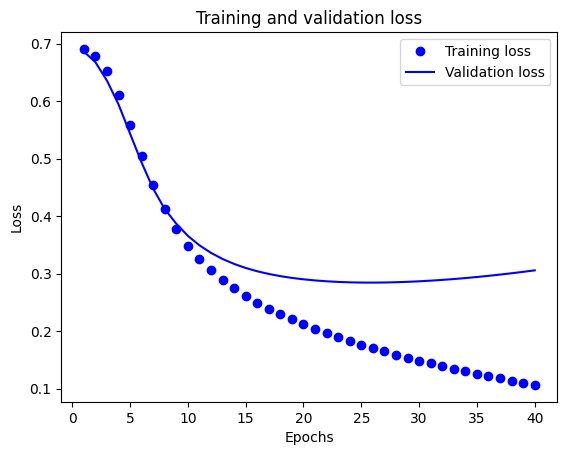

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

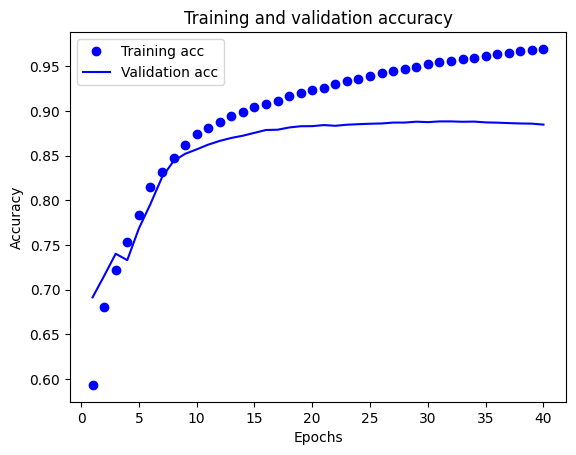

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 기온 예측 문제


이 데이터셋에는 수년간에 걸쳐 (기온, 기압, 습도, 풍향 등과 같은) 14개의 관측치가 10분마다 기록되어 있습니다. 원본 데이터는 2003년부터 기록되어 있지만 이 예제에서는 2009~2016년 사이의 데이터만 사용합니다. 이 데이터셋은 시계열 수치 데이터를 다루는 법을 익히는 데 안성맞춤입니다. 최근 데이터(몇 일치 데이터 포인트)를 입력으로 사용해 모델을 만들고 24시간 이후의 기온을 예측하겠습니다.

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip /content/jena_climate_2009_2016.csv.zip

--2025-11-15 05:32:53--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.65.184, 16.15.202.80, 52.216.216.160, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.65.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.82MB/s    in 2.2s    

2025-11-15 05:32:56 (5.82 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  /content/jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [ ]:
import os

f = open('/content/jena_climate_2009_2016.csv')
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


420,551개 데이터 전체를 넘파이 배열로 바꿉니다:

??????이유?????? ->42만개->데이터가 많음->속도 때문에->처리 하기 위해서.

In [ ]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values


예를 들어 다음은 시간에 따른 기온(섭씨) 그래프입니다:

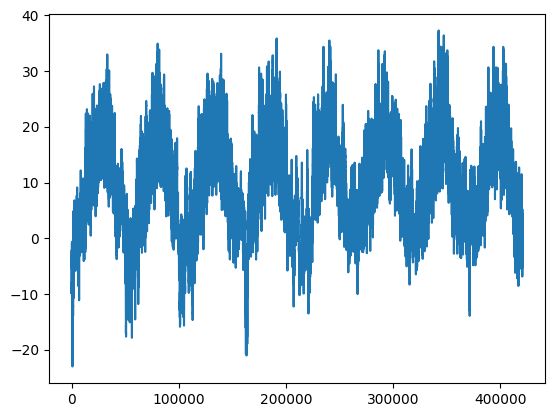

In [ ]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # 온도(섭씨)
plt.plot(range(len(temp)), temp)
plt.show()


이 그래프에서 온도에 주기성이 있다는 것을 잘 볼 수 있습니다.

다음은 기간을 좁혀서 처음 10일간의 온도 데이터를 나타낸 그래프입니다. 10분마다 데이터가 기록되므로 하루에 총 144개의 데이터 포인트가 있습니다:

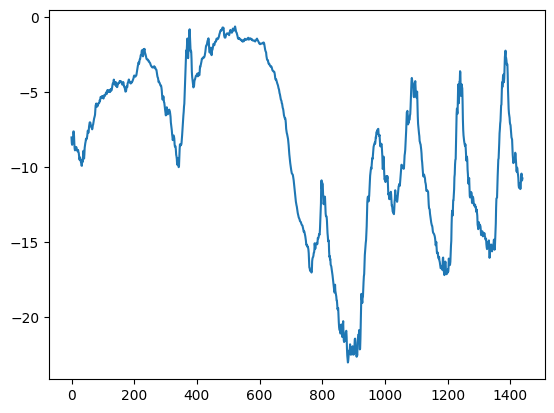

In [ ]:
plt.plot(range(1440), temp[:1440])
plt.show()


이 그래프에서 일별 주기성을 볼 수 있습니다. 특히 마지막 4일간을 보면 확실합니다. 이 데이터는 아주 추운 겨울 중 10일입니다.

지난 몇 달간의 데이터를 사용해 다음 달의 평균 온도를 예측하는 문제는 쉬운 편입니다. 연간 데이터 주기성은 안정적이기 때문입니다. 하지만 하루 하루 데이터를 살펴보면 온도 변화는 매우 불안정합니다. 일자별 수준의 시계열 데이터를 예측할 수 있을까요? 직접 확인해 보겠습니다.

## Preparing the data

이 문제의 정확한 정의는 다음과 같습니다. lookback 타임스텝(하나의 타임스텝은 10분입니다)만큼 이전으로 돌아가서 매 steps 타임스텝마다 샘플링합니다. 이 데이터를 바탕으로 delay 타임스텝 이후의 온도를 예측할 수 있을까요? 사용할 변수는 다음과 같습니다.

 - lookback = 1440 : 10일 전 데이터로 돌아갑니다.
 - steps = 6 : 한 시간마다 데이터 포인트 하나를 샘플링합니다.
 - delay = 144 : 24시간이 지난 데이터가 타깃이 됩니다.

시작하기 전에 두 가지 작업을 처리해야 합니다:

- 신경망에 주입할 수 있는 형태로 데이터를 전처리합니다. 데이터가 이미 수치형이므로 추가적인 벡터화가 필요하지 않습니다. 하지만 데이터에 있는 각 시계열 특성의 범위가 서로 다릅니다(예를 들어 온도는 일반적으로 -20도에서 +30도 사이이고, 밀리바(mb)로 측정된 기압은 1,000 근처의 값입니다). 각 시계열 특성을 개별적으로 정규화하여 비슷한 범위를 가진 작은 값으로 바꾸겠습니다.

- float_data 배열을 받아 과거 데이터의 배치와 미래 타깃 온도를 추출하는 파이썬 제너레이터를 만듭니다. 이 데이터셋에 있는 샘플은 중복이 많습니다(샘플 N과 샘플 N + 1은 대부분 타임스텝이 비슷합니다). 모든 샘플을 각기 메모리에 적재하는 것은 낭비가 심하므로 대신에 원본 데이터를 사용해 그때 그때 배치를 만들겠습니다.
각 시계열 특성에 대해 평균을 빼고 표준 편차로 나누어 전처리합니다. 처음 200,000개 타임스텝을 훈련 데이터로 사용할 것이므로 전체 데이터에서 200,000개만 사용하여 평균과 표준 편차를 계산합니다:

In [ ]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std


다음은 여기서 사용할 제너레이터입니다. 이 제너레이터 함수는 (samples, targets) 튜플을 반복적으로 반환합니다. samples는 입력 데이터로 사용할 배치이고 targets은 이에 대응되는 타깃 온도의 배열입니다. 이 제너레이터 함수는 다음과 같은 매개변수가 있습니다:

- data : 코드 6-32에서 정규화한 부동 소수 데이터로 이루어진 원본 배열
- lookback : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
- delay : 타깃으로 사용할 미래의 타임스텝
- min_index와 max_index : 추출할 타임스텝의 범위를 지정하기 위한 data 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용합니다.
- shuffle : 샘플을 섞을지 시간 순서대로 추출할지 결정합니다.
- batch_size : 배치의 샘플 수
- step : 데이터를 샘플링할 타임스텝 간격. 한 시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정하겠습니다.

In [ ]:
def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=16, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),lookback // step,data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets #yield : 생성자 , 현재 함수를 중단하고 함수 바깥의 코드가 실행되도록 만드는 문법.

이제 generator 함수를 사용해 훈련용, 검증용, 테스트용으로 세 개의 제너레이터를 만들어 보죠. 각 제너레이터는 원본 데이터에서 다른 시간대를 사용합니다. 훈련 제너레이터는 처음 200,000개 타임스텝을 사용하고 검증 제너레이터는 그 다음 100,000개를 사용하고 테스트 제너레이터는 나머지를 사용합니다.

In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size = 16

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

상식 수준의 기준점
블랙 박스 같은 딥러닝 모델을 사용해 온도 예측 문제를 풀기 전에 간단한 상식 수준의 해법을 시도해 보겠습니다. 이는 정상 여부 확인을 위한 용도이고 고수준 머신 러닝 모델이라면 뛰어 넘어야 할 기준점을 만듭니다. 이런 상식 수준의 해법은 알려진 해결책이 없는 새로운 문제를 다루어야 할 때 유용합니다. 일부 클래스가 월등히 많아 불균형한 분류 문제가 고전적인 예입니다. 데이터셋에 클래스 A의 샘플이 90%, 클래스 B의 샘플이 10%가 있다면, 이 분류 문제에 대한 상식 수준의 접근법은 새로운 샘플을 항상 클래스 'A'라고 예측하는 것입니다. 이 분류기는 전반적으로 90%의 정확도를 낼 것입니다. 머신 러닝 기반의 모델이라면 90% 이상을 달성해야 유용하다고 볼 수 있습니다. 이따금 이런 기본적인 기준점을 넘어서기가 아주 어려운 경우가 있습니다.

이 경우 온도 시계열 데이터는 연속성이 있고 일자별로 주기성을 가진다고 가정할 수 있습니다(오늘 온도는 내일 온도와 비슷할 가능성이 높습니다). 그렇기 때문에 상식 수준의 해결책은 지금으로부터 24시간 후의 온도는 지금과 동일하다고 예측하는 것입니다. 이 방법을 평균 절댓값 오차(MAE)로 평가해 보겠습니다:


np.mean(np.abs(preds - targets))


다음은 평가를 위한 반복 루프입니다:

In [ ]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.2895568298927778


In [ ]:
0.29 * std[1]

np.float64(2.5672247338393395)


출력된 MAE는 0.29입니다. 이 온도 데이터는 평균이 0이고 표준 편차가 1이므로 결괏값이 바로 와 닿지는 않습니다. 평균 절댓값 오차 0.29에 표준 편차를 곱하면 섭씨 2.57°C가 됩니다. 평균 절댓값 오차가 상당히 크네요. 이제 딥러닝 모델이 더 나은지 시도해 봅시다.

기본적인 머신 러닝 방법
머신 러닝 모델을 시도하기 전에 상식 수준의 기준점을 세워 놓았습니다. 비슷하게 RNN처럼 복잡하고 연산 비용이 많이 드는 모델을 시도하기 전에 간단하고 손쉽게 만들 수 있는 머신 러닝 모델(예를 들면 소규모의 완전 연결 네트워크)을 먼저 만드는 것이 좋습니다. 이를 바탕으로 더 복잡한 방법을 도입하는 근거가 마련되고 실제적인 이득도 얻게 될 것입니다.

다음 코드는 데이터를 펼쳐서 두 개의 Dense 층을 통과시키는 완전 연결 네트워크를 보여줍니다. 전형적인 회귀 문제이므로 마지막 Dense 층에 활성화 함수를 두지 않았습니다. 손실 함수는 MAE입니다. 상식 수준의 방법에서 사용한 것과 동일한 데이터와 지표를 사용했으므로 결과를 바로 비교해볼 수 있습니다.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae') #ETA : Estimated Time of Arrival
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


AttributeError: 'Sequential' object has no attribute 'fit_generator'

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

일부 검증 손실은 학습을 사용하지 않은 기준점에 가깝지만 안정적이지 못합니다. 앞서 기준 모델을 만든 것이 도움이 됩니다. 이 문제는 기준 모델의 성능을 앞지르기가 쉽지 않습니다. 우리가 적용한 상식에는 머신 러닝 모델이 찾지 못한 핵심 정보가 많이 포함되어 있습니다.

간단하고 괜찮은 성능을 내는 모델(상식 수준의 기준 모델)이 데이터와 타깃을 매핑할 수 있다면 왜 훈련한 모델은 이를 찾지 못하고 성능이 낮을까요? 훈련 과정이 찾는 것은 간단한 이 모델이 아니기 때문입니다. 문제 해결을 위해 탐색하는 모델의 공간, 즉 가설 공간은 우리가 매개변수로 설정한 두 개 층을 가진 네트워크의 모든 가능한 가중치의 조합입니다. 이 네트워크는 이미 매우 복잡합니다. 복잡한 모델 공간에서 해결책을 탐색할 때 간단하고 괜찮은 성능을 내는 모델은 찾지 못할 수 있습니다. 심지어 기술적으로 봤을 때 이 가설 공간에 포함되어 있을 때 조차도 말이죠. 이것이 일반적으로 머신 러닝이 가진 심각한 제약 사항입니다. 학습 알고리즘이 특정한 종류의 간단한 모델을 찾도록 하드코딩되지 않았다면, 모델 파라미터를 학습하는 방법은 간단한 문제를 위한 간단한 해결책을 찾지 못할 수 있습니다.

##  첫 번째 순환 신경망


첫 번째 완전 연결 네트워크는 잘 작동하지 않았습니다. 그렇다고 이 문제에 머신 러닝이 적합하지 않다는 뜻은 아닙니다. 앞선 모델은 시계열 데이터를 펼쳤기 때문에 입력 데이터에서 시간 개념을 잃어버렸습니다. 대신 인과 관계와 순서가 의미가 있는 시퀀스 데이터 그대로 사용해 보겠습니다. 이런 시퀀스 데이터에 아주 잘 들어맞는 순환 시퀀스 처리 모델을 시도해 보겠습니다. 이 모델은 앞선 모델과 달리 데이터 포인터의 시간 순서를 사용합니다.

이전 절에서 소개한 LSTM 층 대신에 2014년에 정준영 등이 개발한 GRU 층을 사용하겠습니다. GRU 층은 LSTM과 같은 원리로 작동하지만 조금 더 간결하고 그래서 계산 비용이 덜 듭니다(LSTM 만큼 표현 학습 능력이 높지는 않을 수 있습니다). 계산 비용과 표현 학습 능력 사이의 트레이드오프(trade-off)는 머신 러닝 어디에서나 등장합니다.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


AttributeError: 'Sequential' object has no attribute 'fit_generator'

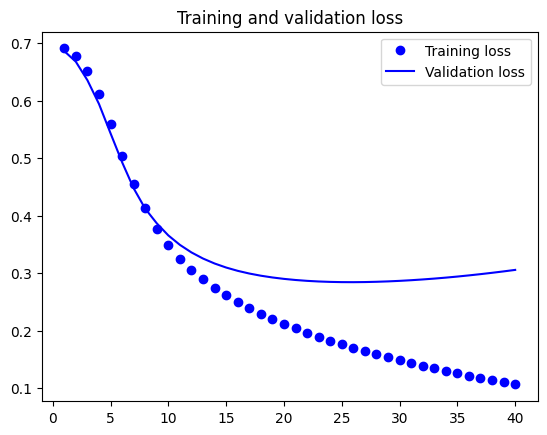

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

훨씬 좋군요! 상식 수준의 모델을 크게 앞질렀습니다. 이 그림은 시퀀스를 펼쳐서 처리하는 완전 연결 네트워크에 비해서 순환 네트워크가 이런 종류의 작업에 훨씬 뛰어나다는 것과 머신 러닝의 가치를 보여줍니다.

새로운 검증 MAE는 0.265 이하(크게 과대적합되기 시작하는 곳)이고 정규화되기 전인 섭씨로 복원하면 MAE는 2.35°C입니다. 초기 에러 2.57°C보다는 확실히 낫지만 더 개선할 수 있을 것 같습니다.

과대적합을 감소하기 위해 순환 드롭아웃 사용하기
훈련 손실과 검증 손실 곡선을 보면 모델이 과대적합인지 알 수 있습니다. 몇 번의 에포크 이후에 훈련 손실과 검증 손실이 현저하게 벌어지기 시작합니다. 이런 현상을 해결하기 위해 잘 알려진 드롭아웃 기법을 이미 보았습니다. 훈련 데이터를 층에 주입할 때 데이터에 있는 우연한 상관 관계를 깨뜨리기 위해 입력 층의 유닛을 랜덤하게 끄는 기법입니다. 순환 신경망에 드롭아웃을 올바르게 적용하는 방법은 간단하지 않습니다. 순환 층 이전에 드롭아웃을 적용하면 규제에 도움이 되는 것보다 학습에 더 방해되는 것으로 오랫동안 알려졌습니다. 2015년 야린 갈이 베이지안 딥러닝에 관한 박사 논문에서 순환 네트워크에 적절하게 드롭아웃을 사용하는 방법을 알아 내었습니다. 타임스텝마다 랜덤하게 드롭아웃 마스크를 바꾸는 것이 아니라 동일한 드롭아웃 마스크(동일한 유닛의 드롭 패턴)를 모든 타임스텝에 적용해야 합니다. GRU이나 LSTM 같은 순환 게이트에 의해 만들어지는 표현을 규제하려면 순환 층 내부 계산에 사용된 활성화 함수에 타임스텝마다 동일한 드롭아웃 마스크를 적용해야 합니다(순환 드롭 아웃 마스크). 모든 타임스텝에 동일한 드롭아웃 마스크를 적용하면 네트워크가 학습 오차를 타임스템에 걸쳐 적절하게 전파시킬 것입니다. 타임스텝마다 랜덤한 드롭아웃 마스크를 적용하면 오차 신호가 전파되는 것을 방해하고 학습 과정에 해를 끼칩니다.

야린 갈은 케라스를 사용해 연구를 하였고 케라스 순환 층에 이 기능을 구현하는 데 도움을 주었습니다. 케라스에 있는 모든 순환 층은 두 개의 드롭아웃 매개변수를 가지고 있습니다. dropout은 층의 입력에 대한 드롭아웃 비율을 정하는 부동 소수 값입니다. recurrent_dropout은 순환 상태의 드롭아웃 비율을 정합니다. GRU 층에 드롭아웃과 순환 드롭아웃을 적용해 과대적합에 어떤 영향을 미치는지 살펴보겠습니다. 드롭아웃으로 규제된 네트워크는 언제나 완전히 수렴하는 데 더 오래 걸립니다. 에포크를 두 배 더 늘려 네트워크를 훈련하겠습니다.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

AttributeError: 'Sequential' object has no attribute 'fit_generator'

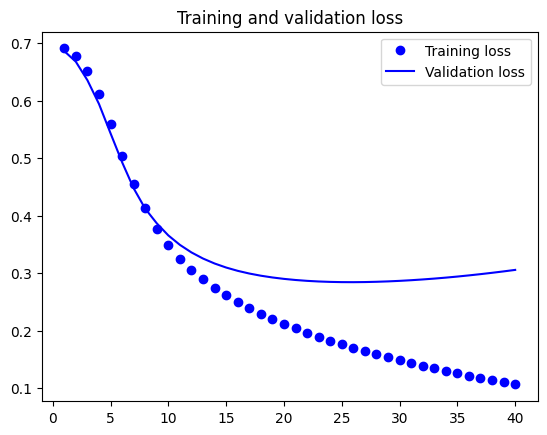

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


성공이네요! 30번째 에포크까지 과대적합이 일어나지 않았습니다. 평가 점수는 안정적이지만 이전보다 더 나아지진 않았습니다.

스태킹 순환 층
과대적합은 더 이상 없지만 성능상의 병목이 있는 것 같으므로 네트워크의 용량을 늘려야 합니다. 일반적인 머신 러닝 작업 흐름을 기억하세요. (드롭아웃 등을 사용하여 과대적합을 줄이는 기본 단계를 거쳤다고 가정하고) 과대적합이 일어날 때까지 네트워크의 용량을 늘리는 것이 좋습니다. 너무 많이 과대적합되지 않는 한 아직 충분한 용량에 도달한 것이 아닙니다.

네트워크의 용량을 늘리려면 일반적으로 층에 있는 유닛의 수를 늘리거나 층을 더 많이 추가합니다. 순환 층 스태킹은 더 강력한 순환 네트워크를 만드는 고전적인 방법입니다. 예를 들어 구글 번역 알고리즘의 현재 성능은 7개의 대규모 LSTM 층을 쌓은 대규모 모델에서 나온 것입니다.

케라스에서 순환 층을 차례대로 쌓으려면 모든 중간 층은 마지막 타임스텝 출력만이 아니고 전체 시퀀스(3D 텐서)를 출력해야 합니다. return_sequences=True로 지정하면 됩니다:

In [ ]:

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

AttributeError: 'Sequential' object has no attribute 'fit_generator'

In [ ]:

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


층을 추가하여 성능을 조금 향상시켰지만 크지는 않습니다. 여기서 두 가지 결론을 얻을 수 있습니다:


- 아직 충분히 과대적합을 만들지 못했기 때문에 검증 손실을 향상하기 위해서 층의 크기를 늘릴 수 있습니다. 하지만 적지 않은 계산 비용이 추가됩니다.

- 층을 추가한 만큼 도움이 되지 않았으므로 여기서는 네트워크의 용량을 늘리는 것이 도움이 되지 않는다고 볼 수 있습니다.

### 양방향 RNN 사용하기


이 절에서 소개할 마지막 기법은 양방향 RNN입니다. 양방향 RNN은 RNN의 한 변종이고 특정 작업에서 기본 RNN 보다 훨씬 좋은 성능을 냅니다. 자연어 처리에서는 맥가이버 칼이라고 할 정도로 즐겨 사용됩니다.

RNN은 특히 순서 또는 시간에 민감합니다. 즉, 입력 시퀀스의 타입스텝 순서대로 처리합니다. 타입스텝을 섞거나 거꾸로 하면 RNN이 시퀀스에서 학습하는 표현을 완전히 바꾸어 버립니다. 이는 온도 예측과 같이 순서에 의미가 있는 문제에 잘 맞는 이유이기도 합니다. 양방향 RNN은 RNN이 순서에 민감하다는 성질을 사용합니다. 앞서 보았던 GRU나 LSTM 같은 RNN 두 개를 사용합니다. 각 RNN은 입력 시퀀스를 한 방향(시간의 순서나 반대 순서)으로 처리한 다음 각 표현을 합칩니다. 시퀀스를 양쪽 방향으로 처리하기 때문에 양방향 RNN은 단방향 RNN이 놓치기 쉬운 패턴을 감지할 수 있습니다.

놀랍게도 이 절에 있는 RNN 층이 시간의 순서대로 (오래된 타임스텝이 먼저 나오도록) 시퀀스를 처리하는 것은 근거 없는 결정입니다. 적어도 이 결정을 궁금해하지 않았습니다. 시간의 반대 방향으로 (최근 타임스텝이 먼저 나오도록) 입력 시퀀스를 처리하면 만족할만한 RNN 성능을 낼 수 있을까요? 실제 이렇게 해 보고 결과가 어떤지 확인해 보죠. 해야 할 일은 입력 시퀀스를 시간 차원을 따라 거꾸로 생성하는 데이터 제너레이터 만드는 것 뿐입니다(제너레이터 함수의 마지막 줄을 yield samples[:, ::-1, :], targets로 바꿉니다). 이 절의 첫 번째 예제와 동일하게 하나의 GRU 층을 가진 네트워크를 훈련합니다:

In [ ]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets

train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


순서를 뒤집은 GRU는 상식 수준의 기준점보다도 성능이 낮습니다. 이 경우에는 시간 순서대로 처리하는 것이 중요한 역할을 합니다. 사실 이는 당연합니다. 기본적인 GRU 층은 먼 과거보다 최근 내용을 잘 기억합니다. 또한, 최근에 가까운 날씨 데이터 포인트일수록 오래된 데이터 포인트보다 예측에 유용합니다(상식 수준의 기준점이 꽤 강력한 이유입니다). 시간 순서대로 처리하는 네트워크가 거꾸로 처리하는 것보다 성능이 높아야만 합니다. 하지만 자연어 처리를 포함하여 다른 많은 문제에서는 그렇지 않습니다. 문장을 이해하는데 있어서 단어의 중요성은 단어가 문장 어디에 놓여 있는지에 따라 결정되지 않습니다. 같은 기법을 이전 절의 LSTM IMDB 예제에 적용해 보죠:

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# 특성으로 사용할 단어의 수
max_features = 10000
# 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
maxlen = 500

# 데이터 로드
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 시퀀스를 뒤집습니다
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# 시퀀스에 패딩을 추가합니다
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

시간 순서로 훈련한 LSTM과 거의 동일한 성능을 얻을 수 있습니다. 놀랍게도 이런 텍스트 데이터셋에는 순서를 뒤집어 처리하는 것이 시간 순서대로 처리하는 것과 거의 동일하게 잘 작동합니다. 이는 언어를 이해하는 데 단어의 순서가 중요하지만 결정적이지는 않다는 가정을 뒷받침합니다. 거꾸로 된 시퀀스에서 훈련한 RNN은 원래 시퀀스에서 훈련한 것과는 다른 표현을 학습합니다. 이와 비슷하게 시작할 때 죽고 마지막 날 태어나는 삶처럼 실제 세상의 시간이 거꾸로 흘러간다면 우리의 정신 세계가 달라질 것입니다. 머신 러닝에서 다른 표현이 유용하다면 항상 사용할 가치가 있습니다. 이 표현이 많이 다를수록 더 좋습니다. 이 표현이 데이터를 바라보는 새로운 시각을 제공하고 다른 방식에서는 놓칠 수 있는 데이터의 특징을 잡아냅니다. 이런 표현은 작업의 성능을 올리는 데 도움을 줍니다. 이것이 다음 장에서 살펴볼 앙상블의 개념입니다.

양방향 RNN은 이 아이디어를 사용하여 시간 순서대로 처리하는 RNN의 성능을 향상시킵니다. 입력 시퀀스를 양쪽 방향으로 바라보기 때문에, 드러나지 않은 다양한 표현을 얻어 시간 순서대로 처리할 때 놓칠 수 있는 패턴을 잡아 냅니다.

<img src = 'https://camo.githubusercontent.com/f1b742d8c7c6b7375bd600596141ed37baba4675/68747470733a2f2f73332e616d617a6f6e6177732e636f6d2f626f6f6b2e6b657261732e696f2f696d672f6368362f6269646972656374696f6e616c5f726e6e2e706e67'>

케라스에서는 Bidirectional 층을 사용하여 양방향 RNN을 만듭니다. 이 클래스는 첫 번째 매개변수로 순환 층의 객체를 전달받습니다. Bidirectional 클래스는 전달받은 순환 층으로 새로운 두 번째 객체를 만듭니다. 하나는 시간 순서대로 입력 시퀀스를 처리하고 다른 하나는 반대 순서로 입력 시퀀스를 처리합니다. IMDB 감성 분석 문제에 이를 적용해 보죠

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:

model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

여기서 얻은 검증 정확도는 88% 정도로 이전 절에서 사용했던 일반 LSTM보다 조금 더 성능이 높습니다. 이 모델은 조금 더 일찍 과대적합되는 것 같습니다. 양방향 순환 층이 단방향 LSTM보다 모델 파라미터가 두 배 많기 때문에 놀라운 일은 아닙니다. 규제를 조금 추가한다면 양항뱡 순환 층을 사용하는 것이 이 작업에 더 적합해 보입니다.

이제 동일한 방식을 온도 예측 문제에 적용해 보죠:

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

더 나아가서


온도 예측 문제의 성능을 향상하기 위해 시도해 볼 수 있는 것들이 많이 있습니다.

- 스태킹한 각 순환 층의 유닛 수를 조정합니다. 지금 설정은 대부분 임의로 한 것이라 최적화가 덜 되었을 것입니다.

- RMSprop 옵티마이저가 사용한 학습률을 조정합니다.

- GRU 대신 LSTM 층을 사용합니다.

- 순환 층 위에 용량이 큰 완전 연결된 회귀 층을 사용합니다. 즉 유닛 수가 많은 Dense 층이나 Dense 층을 스태킹합니다.

- 최종적으로 (검증 MAE 기준으로 봤을 때) 최선의 모델을 테스트 세트에서 확인해야 합니다. 이를 잊으면 검증 세트에 과대적합된 네트워크 구조를 만들게 될 것입니다.

늘 그렇듯이 딥러닝은 과학보다는 예술에 가깝습니다. 어떤 문제에 적합하거나 그렇지 않은 가이드라인은 제시할 수 있지만 결국 모든 문제는 다릅니다. 경험을 바탕으로 다른 전략들을 시도해 봐야 합니다. 현재는 문제를 해결하는 최선의 방법을 미리 알 수 있는 이론이 없습니다. 반복해서 시도해야 합니다.

참고 : Building your Recurrent Neural Network - Step by Step(https://github.com/Kulbear/deep-learning-coursera/blob/master/Sequence%20Models/Building%20a%20Recurrent%20Neural%20Network%20-%20Step%20by%20Step%20-%20v2.ipynb)

참고 : https://junstar92.tistory.com/128